# **Settings**

In [1]:
# !pip install decord
# !pip install accelerate -U
# !pip install -q pytorchvideo transformers evaluate

# **데이터 불러오기**

In [1]:
# 데이터 목록 확인하기
from glob import glob

dir = glob('unstaffed_stores_data/train/*')
print(dir)

['unstaffed_stores_data/train\\catch', 'unstaffed_stores_data/train\\insert', 'unstaffed_stores_data/train\\normal', 'unstaffed_stores_data/train\\put']


In [2]:
dataset_root_path = "unstaffed_stores_data"

In [3]:
import pathlib


dataset_root_path = pathlib.Path(dataset_root_path)
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[WindowsPath('unstaffed_stores_data/train/catch/catch.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_0.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_1.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_10.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_100.mp4')]

In [4]:
# 클래스 라벨링하기
class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})       # 폴더명(class명) 가져오기
label2id = {label: i for i, label in enumerate(class_labels)}           # 라벨 : ID
id2label = {i: label for label, i in label2id.items()}                  # ID : 라벨

print(f"Unique classes: {list(label2id.keys())}.")                      # 라벨 출력하기

Unique classes: ['catch', 'insert', 'normal', 'put'].


In [5]:
print(label2id)
print(id2label)

{'catch': 0, 'insert': 1, 'normal': 2, 'put': 3}
{0: 'catch', 1: 'insert', 2: 'normal', 3: 'put'}


# **모델 Settings**

In [6]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


# **Pretrained 모델 불러오기**

In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    # ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
    ignore_mismatched_sizes=False,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **전처리 설정하기**

In [8]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **기존 모델의 정보**

In [9]:
image_processor

VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "VideoMAEFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [10]:
model.config

VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base",
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "catch",
    "1": "insert",
    "2": "normal",
    "3": "put"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "catch": 0,
    "insert": 1,
    "normal": 2,
    "put": 3
  },
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "tubelet_size": 2,
  "use_mean_pooling": false
}

In [11]:
# 전처리 설정하기
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)
print(resize_to)

num_frames_to_sample = model.config.num_frames
sample_rate = 44100
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

(224, 224)


# **Data Transform**

In [12]:
import os

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # RandomShortSideScale(min_size=224, max_size=224),
                    # RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

dataset_root_path = "unstaffed_stores_data"
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [13]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [14]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

4786 176 174


In [15]:
# !pip install imageio

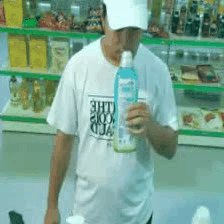

In [16]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [17]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-model"
num_epochs = 6
batch_size = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    # learning_rate=5e-6,
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [18]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [19]:
import torch
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [20]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [24]:
import numpy as np

train_results = trainer.train()

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: isakin. Use `wandb login --relogin` to force relogin


  0%|          | 0/7176 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  0%|          | 10/7176 [00:11<1:28:46,  1.35it/s]

{'loss': 1.4909, 'learning_rate': 6.963788300835655e-07, 'epoch': 0.0}


  0%|          | 20/7176 [00:18<1:19:58,  1.49it/s]

{'loss': 1.4158, 'learning_rate': 1.392757660167131e-06, 'epoch': 0.0}


  0%|          | 30/7176 [00:25<1:19:37,  1.50it/s]

{'loss': 1.4308, 'learning_rate': 2.0891364902506964e-06, 'epoch': 0.0}


  1%|          | 40/7176 [00:32<1:20:33,  1.48it/s]

{'loss': 1.412, 'learning_rate': 2.785515320334262e-06, 'epoch': 0.01}


  1%|          | 50/7176 [00:38<1:23:03,  1.43it/s]

{'loss': 1.4452, 'learning_rate': 3.4818941504178276e-06, 'epoch': 0.01}


  1%|          | 60/7176 [00:46<1:23:42,  1.42it/s]

{'loss': 1.3554, 'learning_rate': 4.178272980501393e-06, 'epoch': 0.01}


  1%|          | 70/7176 [00:53<1:21:35,  1.45it/s]

{'loss': 1.368, 'learning_rate': 4.874651810584958e-06, 'epoch': 0.01}


  1%|          | 80/7176 [01:00<1:29:20,  1.32it/s]

{'loss': 1.3377, 'learning_rate': 5.571030640668524e-06, 'epoch': 0.01}


  1%|▏         | 90/7176 [01:07<1:23:09,  1.42it/s]

{'loss': 1.3165, 'learning_rate': 6.267409470752089e-06, 'epoch': 0.01}


  1%|▏         | 100/7176 [01:14<1:21:54,  1.44it/s]

{'loss': 1.2751, 'learning_rate': 6.963788300835655e-06, 'epoch': 0.01}


  2%|▏         | 110/7176 [01:21<1:21:59,  1.44it/s]

{'loss': 1.239, 'learning_rate': 7.66016713091922e-06, 'epoch': 0.02}


  2%|▏         | 120/7176 [01:28<1:25:04,  1.38it/s]

{'loss': 1.2111, 'learning_rate': 8.356545961002786e-06, 'epoch': 0.02}


  2%|▏         | 130/7176 [01:35<1:27:08,  1.35it/s]

{'loss': 1.1647, 'learning_rate': 9.05292479108635e-06, 'epoch': 0.02}


  2%|▏         | 140/7176 [01:42<1:23:19,  1.41it/s]

{'loss': 1.1218, 'learning_rate': 9.749303621169916e-06, 'epoch': 0.02}


  2%|▏         | 150/7176 [01:49<1:24:58,  1.38it/s]

{'loss': 0.9552, 'learning_rate': 1.0445682451253484e-05, 'epoch': 0.02}


  2%|▏         | 160/7176 [01:56<1:22:56,  1.41it/s]

{'loss': 0.8167, 'learning_rate': 1.1142061281337048e-05, 'epoch': 0.02}


  2%|▏         | 170/7176 [02:03<1:24:19,  1.38it/s]

{'loss': 0.7868, 'learning_rate': 1.1838440111420614e-05, 'epoch': 0.02}


  3%|▎         | 180/7176 [02:10<1:24:40,  1.38it/s]

{'loss': 0.6277, 'learning_rate': 1.2534818941504178e-05, 'epoch': 0.03}


  3%|▎         | 190/7176 [02:17<1:19:54,  1.46it/s]

{'loss': 0.5674, 'learning_rate': 1.3231197771587744e-05, 'epoch': 0.03}


  3%|▎         | 200/7176 [02:24<1:21:47,  1.42it/s]

{'loss': 0.6083, 'learning_rate': 1.392757660167131e-05, 'epoch': 0.03}


  3%|▎         | 210/7176 [02:31<1:24:48,  1.37it/s]

{'loss': 0.4015, 'learning_rate': 1.4623955431754876e-05, 'epoch': 0.03}


  3%|▎         | 220/7176 [02:38<1:22:00,  1.41it/s]

{'loss': 0.5545, 'learning_rate': 1.532033426183844e-05, 'epoch': 0.03}


  3%|▎         | 230/7176 [02:45<1:22:23,  1.41it/s]

{'loss': 0.4473, 'learning_rate': 1.6016713091922005e-05, 'epoch': 0.03}


  3%|▎         | 240/7176 [02:52<1:20:25,  1.44it/s]

{'loss': 0.4113, 'learning_rate': 1.671309192200557e-05, 'epoch': 0.03}


  3%|▎         | 250/7176 [02:59<1:21:45,  1.41it/s]

{'loss': 0.2801, 'learning_rate': 1.7409470752089137e-05, 'epoch': 0.03}


  4%|▎         | 260/7176 [03:06<1:20:32,  1.43it/s]

{'loss': 0.3183, 'learning_rate': 1.81058495821727e-05, 'epoch': 0.04}


  4%|▍         | 270/7176 [03:13<1:19:19,  1.45it/s]

{'loss': 0.31, 'learning_rate': 1.8802228412256266e-05, 'epoch': 0.04}


  4%|▍         | 280/7176 [03:20<1:20:24,  1.43it/s]

{'loss': 0.2433, 'learning_rate': 1.9498607242339832e-05, 'epoch': 0.04}


  4%|▍         | 290/7176 [03:27<1:23:03,  1.38it/s]

{'loss': 0.3317, 'learning_rate': 2.01949860724234e-05, 'epoch': 0.04}


  4%|▍         | 300/7176 [03:34<1:18:54,  1.45it/s]

{'loss': 0.1471, 'learning_rate': 2.0891364902506967e-05, 'epoch': 0.04}


  4%|▍         | 310/7176 [03:41<1:19:38,  1.44it/s]

{'loss': 0.223, 'learning_rate': 2.158774373259053e-05, 'epoch': 0.04}


  4%|▍         | 320/7176 [03:48<1:27:10,  1.31it/s]

{'loss': 0.1758, 'learning_rate': 2.2284122562674096e-05, 'epoch': 0.04}


  5%|▍         | 330/7176 [03:55<1:19:09,  1.44it/s]

{'loss': 0.353, 'learning_rate': 2.2980501392757662e-05, 'epoch': 0.05}


  5%|▍         | 340/7176 [04:02<1:18:45,  1.45it/s]

{'loss': 0.3524, 'learning_rate': 2.3676880222841228e-05, 'epoch': 0.05}


  5%|▍         | 350/7176 [04:10<1:22:58,  1.37it/s]

{'loss': 0.4014, 'learning_rate': 2.4373259052924794e-05, 'epoch': 0.05}


  5%|▌         | 360/7176 [04:17<1:21:48,  1.39it/s]

{'loss': 0.3413, 'learning_rate': 2.5069637883008357e-05, 'epoch': 0.05}


  5%|▌         | 370/7176 [04:24<1:18:43,  1.44it/s]

{'loss': 0.2551, 'learning_rate': 2.5766016713091923e-05, 'epoch': 0.05}


  5%|▌         | 380/7176 [04:31<1:18:24,  1.44it/s]

{'loss': 0.3236, 'learning_rate': 2.646239554317549e-05, 'epoch': 0.05}


  5%|▌         | 390/7176 [04:38<1:19:34,  1.42it/s]

{'loss': 0.1972, 'learning_rate': 2.7158774373259055e-05, 'epoch': 0.05}


  6%|▌         | 400/7176 [04:45<1:20:31,  1.40it/s]

{'loss': 0.2949, 'learning_rate': 2.785515320334262e-05, 'epoch': 0.06}


  6%|▌         | 410/7176 [04:52<1:18:20,  1.44it/s]

{'loss': 0.1261, 'learning_rate': 2.8551532033426187e-05, 'epoch': 0.06}


  6%|▌         | 420/7176 [04:59<1:18:44,  1.43it/s]

{'loss': 0.1482, 'learning_rate': 2.9247910863509753e-05, 'epoch': 0.06}


  6%|▌         | 430/7176 [05:06<1:20:13,  1.40it/s]

{'loss': 0.1889, 'learning_rate': 2.9944289693593312e-05, 'epoch': 0.06}


  6%|▌         | 440/7176 [05:13<1:21:03,  1.38it/s]

{'loss': 0.0891, 'learning_rate': 3.064066852367688e-05, 'epoch': 0.06}


  6%|▋         | 450/7176 [05:21<1:22:02,  1.37it/s]

{'loss': 0.1317, 'learning_rate': 3.133704735376045e-05, 'epoch': 0.06}


  6%|▋         | 460/7176 [05:28<1:17:28,  1.44it/s]

{'loss': 0.2689, 'learning_rate': 3.203342618384401e-05, 'epoch': 0.06}


  7%|▋         | 470/7176 [05:35<1:19:20,  1.41it/s]

{'loss': 0.0842, 'learning_rate': 3.272980501392758e-05, 'epoch': 0.07}


  7%|▋         | 480/7176 [05:42<1:16:44,  1.45it/s]

{'loss': 0.1458, 'learning_rate': 3.342618384401114e-05, 'epoch': 0.07}


  7%|▋         | 490/7176 [05:49<1:19:53,  1.39it/s]

{'loss': 0.2882, 'learning_rate': 3.412256267409471e-05, 'epoch': 0.07}


  7%|▋         | 500/7176 [05:56<1:23:40,  1.33it/s]

{'loss': 0.3162, 'learning_rate': 3.4818941504178274e-05, 'epoch': 0.07}


  7%|▋         | 510/7176 [06:03<1:15:12,  1.48it/s]

{'loss': 0.3199, 'learning_rate': 3.5515320334261844e-05, 'epoch': 0.07}


  7%|▋         | 520/7176 [06:10<1:20:41,  1.37it/s]

{'loss': 0.2248, 'learning_rate': 3.62116991643454e-05, 'epoch': 0.07}


  7%|▋         | 530/7176 [06:17<1:17:03,  1.44it/s]

{'loss': 0.1135, 'learning_rate': 3.690807799442897e-05, 'epoch': 0.07}


  8%|▊         | 540/7176 [06:24<1:18:10,  1.41it/s]

{'loss': 0.1662, 'learning_rate': 3.760445682451253e-05, 'epoch': 0.08}


  8%|▊         | 550/7176 [06:31<1:18:49,  1.40it/s]

{'loss': 0.0885, 'learning_rate': 3.83008356545961e-05, 'epoch': 0.08}


  8%|▊         | 560/7176 [06:39<1:20:07,  1.38it/s]

{'loss': 0.2102, 'learning_rate': 3.8997214484679664e-05, 'epoch': 0.08}


  8%|▊         | 570/7176 [06:46<1:17:55,  1.41it/s]

{'loss': 0.1485, 'learning_rate': 3.969359331476323e-05, 'epoch': 0.08}


  8%|▊         | 580/7176 [06:53<1:17:21,  1.42it/s]

{'loss': 0.2631, 'learning_rate': 4.03899721448468e-05, 'epoch': 0.08}


  8%|▊         | 590/7176 [07:00<1:17:52,  1.41it/s]

{'loss': 0.0455, 'learning_rate': 4.1086350974930365e-05, 'epoch': 0.08}


  8%|▊         | 599/7176 [07:05<52:47,  2.08it/s]  c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  8%|▊         | 599/7176 [07:17<52:47,  2.08it/s]

{'eval_loss': 0.2210868000984192, 'eval_accuracy': 0.9431818181818182, 'eval_runtime': 11.79, 'eval_samples_per_second': 14.928, 'eval_steps_per_second': 1.866, 'epoch': 0.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  8%|▊         | 600/7176 [07:19<8:03:30,  4.41s/it]

{'loss': 0.0591, 'learning_rate': 4.1782729805013935e-05, 'epoch': 1.0}


  9%|▊         | 610/7176 [07:26<1:24:34,  1.29it/s]

{'loss': 0.2099, 'learning_rate': 4.24791086350975e-05, 'epoch': 1.0}


  9%|▊         | 620/7176 [07:32<1:10:38,  1.55it/s]

{'loss': 0.2391, 'learning_rate': 4.317548746518106e-05, 'epoch': 1.0}


  9%|▉         | 630/7176 [07:39<1:13:49,  1.48it/s]

{'loss': 0.0322, 'learning_rate': 4.387186629526462e-05, 'epoch': 1.0}


  9%|▉         | 640/7176 [07:46<1:12:53,  1.49it/s]

{'loss': 0.175, 'learning_rate': 4.456824512534819e-05, 'epoch': 1.01}


  9%|▉         | 650/7176 [07:53<1:15:39,  1.44it/s]

{'loss': 0.0861, 'learning_rate': 4.5264623955431755e-05, 'epoch': 1.01}


  9%|▉         | 660/7176 [08:00<1:18:22,  1.39it/s]

{'loss': 0.1325, 'learning_rate': 4.5961002785515324e-05, 'epoch': 1.01}


  9%|▉         | 670/7176 [08:07<1:13:41,  1.47it/s]

{'loss': 0.1006, 'learning_rate': 4.665738161559889e-05, 'epoch': 1.01}


  9%|▉         | 680/7176 [08:14<1:14:33,  1.45it/s]

{'loss': 0.1045, 'learning_rate': 4.7353760445682456e-05, 'epoch': 1.01}


 10%|▉         | 690/7176 [08:21<1:11:36,  1.51it/s]

{'loss': 0.3301, 'learning_rate': 4.805013927576602e-05, 'epoch': 1.01}


 10%|▉         | 700/7176 [08:28<1:16:19,  1.41it/s]

{'loss': 0.1042, 'learning_rate': 4.874651810584959e-05, 'epoch': 1.01}


 10%|▉         | 710/7176 [08:34<1:15:02,  1.44it/s]

{'loss': 0.1406, 'learning_rate': 4.9442896935933144e-05, 'epoch': 1.02}


 10%|█         | 720/7176 [08:41<1:12:25,  1.49it/s]

{'loss': 0.1762, 'learning_rate': 4.998451532982348e-05, 'epoch': 1.02}


 10%|█         | 730/7176 [08:48<1:12:28,  1.48it/s]

{'loss': 0.1654, 'learning_rate': 4.990709197894085e-05, 'epoch': 1.02}


 10%|█         | 740/7176 [08:55<1:16:38,  1.40it/s]

{'loss': 0.2787, 'learning_rate': 4.982966862805822e-05, 'epoch': 1.02}


 10%|█         | 750/7176 [09:02<1:12:33,  1.48it/s]

{'loss': 0.0078, 'learning_rate': 4.97522452771756e-05, 'epoch': 1.02}


 11%|█         | 760/7176 [09:09<1:15:13,  1.42it/s]

{'loss': 0.1291, 'learning_rate': 4.9674821926292976e-05, 'epoch': 1.02}


 11%|█         | 770/7176 [09:16<1:11:32,  1.49it/s]

{'loss': 0.1795, 'learning_rate': 4.959739857541035e-05, 'epoch': 1.02}


 11%|█         | 780/7176 [09:23<1:11:12,  1.50it/s]

{'loss': 0.2203, 'learning_rate': 4.951997522452772e-05, 'epoch': 1.03}


 11%|█         | 790/7176 [09:29<1:13:26,  1.45it/s]

{'loss': 0.1282, 'learning_rate': 4.9442551873645095e-05, 'epoch': 1.03}


 11%|█         | 800/7176 [09:36<1:12:15,  1.47it/s]

{'loss': 0.1818, 'learning_rate': 4.9365128522762466e-05, 'epoch': 1.03}


 11%|█▏        | 810/7176 [09:43<1:13:07,  1.45it/s]

{'loss': 0.065, 'learning_rate': 4.928770517187984e-05, 'epoch': 1.03}


 11%|█▏        | 820/7176 [09:50<1:15:21,  1.41it/s]

{'loss': 0.0824, 'learning_rate': 4.9210281820997215e-05, 'epoch': 1.03}


 12%|█▏        | 830/7176 [09:57<1:11:32,  1.48it/s]

{'loss': 0.1875, 'learning_rate': 4.913285847011459e-05, 'epoch': 1.03}


 12%|█▏        | 840/7176 [10:04<1:14:12,  1.42it/s]

{'loss': 0.1345, 'learning_rate': 4.905543511923196e-05, 'epoch': 1.03}


 12%|█▏        | 850/7176 [10:11<1:12:48,  1.45it/s]

{'loss': 0.0165, 'learning_rate': 4.8978011768349334e-05, 'epoch': 1.03}


 12%|█▏        | 860/7176 [10:18<1:10:19,  1.50it/s]

{'loss': 0.0958, 'learning_rate': 4.890058841746671e-05, 'epoch': 1.04}


 12%|█▏        | 870/7176 [10:25<1:17:24,  1.36it/s]

{'loss': 0.0838, 'learning_rate': 4.882316506658409e-05, 'epoch': 1.04}


 12%|█▏        | 880/7176 [10:32<1:09:12,  1.52it/s]

{'loss': 0.0407, 'learning_rate': 4.874574171570146e-05, 'epoch': 1.04}


 12%|█▏        | 890/7176 [10:39<1:09:39,  1.50it/s]

{'loss': 0.1094, 'learning_rate': 4.866831836481883e-05, 'epoch': 1.04}


 13%|█▎        | 900/7176 [10:45<1:10:06,  1.49it/s]

{'loss': 0.0336, 'learning_rate': 4.859089501393621e-05, 'epoch': 1.04}


 13%|█▎        | 910/7176 [10:52<1:11:38,  1.46it/s]

{'loss': 0.275, 'learning_rate': 4.851347166305358e-05, 'epoch': 1.04}


 13%|█▎        | 920/7176 [10:59<1:11:01,  1.47it/s]

{'loss': 0.2013, 'learning_rate': 4.843604831217095e-05, 'epoch': 1.04}


 13%|█▎        | 930/7176 [11:06<1:11:50,  1.45it/s]

{'loss': 0.2603, 'learning_rate': 4.835862496128833e-05, 'epoch': 1.05}


 13%|█▎        | 940/7176 [11:13<1:09:22,  1.50it/s]

{'loss': 0.0748, 'learning_rate': 4.8281201610405705e-05, 'epoch': 1.05}


 13%|█▎        | 950/7176 [11:20<1:11:37,  1.45it/s]

{'loss': 0.2656, 'learning_rate': 4.8203778259523076e-05, 'epoch': 1.05}


 13%|█▎        | 960/7176 [11:27<1:10:47,  1.46it/s]

{'loss': 0.0743, 'learning_rate': 4.812635490864045e-05, 'epoch': 1.05}


 14%|█▎        | 970/7176 [11:34<1:13:04,  1.42it/s]

{'loss': 0.0498, 'learning_rate': 4.804893155775782e-05, 'epoch': 1.05}


 14%|█▎        | 980/7176 [11:40<1:08:42,  1.50it/s]

{'loss': 0.101, 'learning_rate': 4.7971508206875195e-05, 'epoch': 1.05}


 14%|█▍        | 990/7176 [11:47<1:09:52,  1.48it/s]

{'loss': 0.0567, 'learning_rate': 4.789408485599257e-05, 'epoch': 1.05}


 14%|█▍        | 1000/7176 [11:54<1:10:28,  1.46it/s]

{'loss': 0.0391, 'learning_rate': 4.7816661505109944e-05, 'epoch': 1.06}


 14%|█▍        | 1010/7176 [12:01<1:10:17,  1.46it/s]

{'loss': 0.1768, 'learning_rate': 4.7739238154227314e-05, 'epoch': 1.06}


 14%|█▍        | 1020/7176 [12:08<1:10:10,  1.46it/s]

{'loss': 0.0621, 'learning_rate': 4.766181480334469e-05, 'epoch': 1.06}


 14%|█▍        | 1030/7176 [12:15<1:10:37,  1.45it/s]

{'loss': 0.0325, 'learning_rate': 4.758439145246206e-05, 'epoch': 1.06}


 14%|█▍        | 1040/7176 [12:22<1:09:35,  1.47it/s]

{'loss': 0.0062, 'learning_rate': 4.750696810157944e-05, 'epoch': 1.06}


 15%|█▍        | 1050/7176 [12:29<1:10:42,  1.44it/s]

{'loss': 0.0012, 'learning_rate': 4.742954475069681e-05, 'epoch': 1.06}


 15%|█▍        | 1060/7176 [12:36<1:10:19,  1.45it/s]

{'loss': 0.0013, 'learning_rate': 4.735212139981419e-05, 'epoch': 1.06}


 15%|█▍        | 1070/7176 [12:43<1:09:50,  1.46it/s]

{'loss': 0.001, 'learning_rate': 4.727469804893156e-05, 'epoch': 1.07}


 15%|█▌        | 1080/7176 [12:50<1:14:26,  1.36it/s]

{'loss': 0.0766, 'learning_rate': 4.719727469804893e-05, 'epoch': 1.07}


 15%|█▌        | 1090/7176 [12:56<1:07:26,  1.50it/s]

{'loss': 0.0448, 'learning_rate': 4.711985134716631e-05, 'epoch': 1.07}


 15%|█▌        | 1100/7176 [13:03<1:11:54,  1.41it/s]

{'loss': 0.0311, 'learning_rate': 4.7042427996283686e-05, 'epoch': 1.07}


 15%|█▌        | 1110/7176 [13:10<1:10:12,  1.44it/s]

{'loss': 0.0036, 'learning_rate': 4.6965004645401056e-05, 'epoch': 1.07}


 16%|█▌        | 1120/7176 [13:17<1:08:04,  1.48it/s]

{'loss': 0.1002, 'learning_rate': 4.688758129451843e-05, 'epoch': 1.07}


 16%|█▌        | 1130/7176 [13:24<1:11:02,  1.42it/s]

{'loss': 0.0943, 'learning_rate': 4.6810157943635805e-05, 'epoch': 1.07}


 16%|█▌        | 1140/7176 [13:31<1:08:18,  1.47it/s]

{'loss': 0.0015, 'learning_rate': 4.6732734592753176e-05, 'epoch': 1.08}


 16%|█▌        | 1150/7176 [13:37<1:08:04,  1.48it/s]

{'loss': 0.1138, 'learning_rate': 4.665531124187055e-05, 'epoch': 1.08}


 16%|█▌        | 1160/7176 [13:44<1:09:05,  1.45it/s]

{'loss': 0.0703, 'learning_rate': 4.6577887890987924e-05, 'epoch': 1.08}


 16%|█▋        | 1170/7176 [13:51<1:07:04,  1.49it/s]

{'loss': 0.0612, 'learning_rate': 4.65004645401053e-05, 'epoch': 1.08}


 16%|█▋        | 1180/7176 [13:58<1:09:01,  1.45it/s]

{'loss': 0.0314, 'learning_rate': 4.642304118922267e-05, 'epoch': 1.08}


 17%|█▋        | 1190/7176 [14:05<1:06:11,  1.51it/s]

{'loss': 0.0653, 'learning_rate': 4.634561783834004e-05, 'epoch': 1.08}


 17%|█▋        | 1198/7176 [14:09<45:12,  2.20it/s]  c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 17%|█▋        | 1198/7176 [14:21<45:12,  2.20it/s]

{'eval_loss': 0.11308612674474716, 'eval_accuracy': 0.9659090909090909, 'eval_runtime': 11.4203, 'eval_samples_per_second': 15.411, 'eval_steps_per_second': 1.926, 'epoch': 1.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 17%|█▋        | 1200/7176 [14:23<5:20:01,  3.21s/it]

{'loss': 0.058, 'learning_rate': 4.6268194487457414e-05, 'epoch': 2.0}


 17%|█▋        | 1210/7176 [14:30<1:17:30,  1.28it/s]

{'loss': 0.0783, 'learning_rate': 4.61907711365748e-05, 'epoch': 2.0}


 17%|█▋        | 1220/7176 [14:37<1:07:33,  1.47it/s]

{'loss': 0.0022, 'learning_rate': 4.611334778569217e-05, 'epoch': 2.0}


 17%|█▋        | 1230/7176 [14:44<1:07:58,  1.46it/s]

{'loss': 0.0036, 'learning_rate': 4.603592443480954e-05, 'epoch': 2.0}


 17%|█▋        | 1240/7176 [14:51<1:07:40,  1.46it/s]

{'loss': 0.0008, 'learning_rate': 4.595850108392691e-05, 'epoch': 2.01}


 17%|█▋        | 1250/7176 [14:58<1:07:21,  1.47it/s]

{'loss': 0.0006, 'learning_rate': 4.588107773304429e-05, 'epoch': 2.01}


 18%|█▊        | 1260/7176 [15:05<1:08:12,  1.45it/s]

{'loss': 0.0473, 'learning_rate': 4.5803654382161666e-05, 'epoch': 2.01}


 18%|█▊        | 1270/7176 [15:12<1:07:46,  1.45it/s]

{'loss': 0.0008, 'learning_rate': 4.572623103127904e-05, 'epoch': 2.01}


 18%|█▊        | 1280/7176 [15:19<1:08:03,  1.44it/s]

{'loss': 0.0294, 'learning_rate': 4.564880768039641e-05, 'epoch': 2.01}


 18%|█▊        | 1290/7176 [15:26<1:07:26,  1.45it/s]

{'loss': 0.1134, 'learning_rate': 4.5571384329513785e-05, 'epoch': 2.01}


 18%|█▊        | 1300/7176 [15:33<1:04:10,  1.53it/s]

{'loss': 0.0022, 'learning_rate': 4.5493960978631156e-05, 'epoch': 2.01}


 18%|█▊        | 1310/7176 [15:39<1:09:10,  1.41it/s]

{'loss': 0.0018, 'learning_rate': 4.541653762774853e-05, 'epoch': 2.02}


 18%|█▊        | 1320/7176 [15:46<1:10:29,  1.38it/s]

{'loss': 0.0135, 'learning_rate': 4.5339114276865905e-05, 'epoch': 2.02}


 19%|█▊        | 1330/7176 [15:53<1:04:46,  1.50it/s]

{'loss': 0.1109, 'learning_rate': 4.526169092598328e-05, 'epoch': 2.02}


 19%|█▊        | 1340/7176 [16:00<1:06:12,  1.47it/s]

{'loss': 0.0006, 'learning_rate': 4.518426757510065e-05, 'epoch': 2.02}


 19%|█▉        | 1350/7176 [16:07<1:07:40,  1.43it/s]

{'loss': 0.0007, 'learning_rate': 4.5106844224218024e-05, 'epoch': 2.02}


 19%|█▉        | 1360/7176 [16:14<1:04:39,  1.50it/s]

{'loss': 0.0416, 'learning_rate': 4.50294208733354e-05, 'epoch': 2.02}


 19%|█▉        | 1370/7176 [16:21<1:06:38,  1.45it/s]

{'loss': 0.0073, 'learning_rate': 4.495199752245277e-05, 'epoch': 2.02}


 19%|█▉        | 1380/7176 [16:28<1:06:12,  1.46it/s]

{'loss': 0.0148, 'learning_rate': 4.487457417157015e-05, 'epoch': 2.03}


 19%|█▉        | 1390/7176 [16:34<1:04:47,  1.49it/s]

{'loss': 0.0478, 'learning_rate': 4.479715082068752e-05, 'epoch': 2.03}


 20%|█▉        | 1400/7176 [16:41<1:06:45,  1.44it/s]

{'loss': 0.0011, 'learning_rate': 4.47197274698049e-05, 'epoch': 2.03}


 20%|█▉        | 1410/7176 [16:48<1:03:46,  1.51it/s]

{'loss': 0.0729, 'learning_rate': 4.464230411892227e-05, 'epoch': 2.03}


 20%|█▉        | 1420/7176 [16:55<1:04:05,  1.50it/s]

{'loss': 0.0005, 'learning_rate': 4.456488076803964e-05, 'epoch': 2.03}


 20%|█▉        | 1430/7176 [17:02<1:11:52,  1.33it/s]

{'loss': 0.0005, 'learning_rate': 4.448745741715702e-05, 'epoch': 2.03}


 20%|██        | 1440/7176 [17:09<1:04:52,  1.47it/s]

{'loss': 0.0603, 'learning_rate': 4.4410034066274395e-05, 'epoch': 2.03}


 20%|██        | 1450/7176 [17:16<1:07:29,  1.41it/s]

{'loss': 0.0745, 'learning_rate': 4.4332610715391766e-05, 'epoch': 2.04}


 20%|██        | 1460/7176 [17:23<1:04:15,  1.48it/s]

{'loss': 0.0005, 'learning_rate': 4.425518736450914e-05, 'epoch': 2.04}


 20%|██        | 1470/7176 [17:29<1:02:39,  1.52it/s]

{'loss': 0.0088, 'learning_rate': 4.417776401362651e-05, 'epoch': 2.04}


 21%|██        | 1480/7176 [17:36<1:05:16,  1.45it/s]

{'loss': 0.0412, 'learning_rate': 4.4100340662743885e-05, 'epoch': 2.04}


 21%|██        | 1490/7176 [17:43<1:03:38,  1.49it/s]

{'loss': 0.0007, 'learning_rate': 4.402291731186126e-05, 'epoch': 2.04}


 21%|██        | 1500/7176 [17:50<1:06:00,  1.43it/s]

{'loss': 0.0017, 'learning_rate': 4.3945493960978634e-05, 'epoch': 2.04}


 21%|██        | 1510/7176 [17:57<1:05:41,  1.44it/s]

{'loss': 0.0008, 'learning_rate': 4.3868070610096004e-05, 'epoch': 2.04}


 21%|██        | 1520/7176 [18:04<1:06:57,  1.41it/s]

{'loss': 0.0005, 'learning_rate': 4.379064725921338e-05, 'epoch': 2.04}


 21%|██▏       | 1530/7176 [18:11<1:04:45,  1.45it/s]

{'loss': 0.0004, 'learning_rate': 4.371322390833075e-05, 'epoch': 2.05}


 21%|██▏       | 1540/7176 [18:18<1:03:43,  1.47it/s]

{'loss': 0.0004, 'learning_rate': 4.363580055744813e-05, 'epoch': 2.05}


 22%|██▏       | 1550/7176 [18:25<1:05:42,  1.43it/s]

{'loss': 0.022, 'learning_rate': 4.35583772065655e-05, 'epoch': 2.05}


 22%|██▏       | 1560/7176 [18:32<1:04:48,  1.44it/s]

{'loss': 0.0004, 'learning_rate': 4.348095385568288e-05, 'epoch': 2.05}


 22%|██▏       | 1570/7176 [18:38<1:03:21,  1.47it/s]

{'loss': 0.0203, 'learning_rate': 4.340353050480025e-05, 'epoch': 2.05}


 22%|██▏       | 1580/7176 [18:45<1:05:39,  1.42it/s]

{'loss': 0.093, 'learning_rate': 4.332610715391762e-05, 'epoch': 2.05}


 22%|██▏       | 1590/7176 [18:52<1:01:57,  1.50it/s]

{'loss': 0.0004, 'learning_rate': 4.3248683803035e-05, 'epoch': 2.05}


 22%|██▏       | 1600/7176 [18:59<1:02:50,  1.48it/s]

{'loss': 0.1225, 'learning_rate': 4.3171260452152376e-05, 'epoch': 2.06}


 22%|██▏       | 1610/7176 [19:06<1:06:46,  1.39it/s]

{'loss': 0.0527, 'learning_rate': 4.3093837101269747e-05, 'epoch': 2.06}


 23%|██▎       | 1620/7176 [19:13<1:03:02,  1.47it/s]

{'loss': 0.0451, 'learning_rate': 4.301641375038712e-05, 'epoch': 2.06}


 23%|██▎       | 1630/7176 [19:20<1:05:56,  1.40it/s]

{'loss': 0.0009, 'learning_rate': 4.2938990399504495e-05, 'epoch': 2.06}


 23%|██▎       | 1640/7176 [19:27<1:10:39,  1.31it/s]

{'loss': 0.0424, 'learning_rate': 4.2861567048621866e-05, 'epoch': 2.06}


 23%|██▎       | 1650/7176 [19:34<1:00:07,  1.53it/s]

{'loss': 0.0165, 'learning_rate': 4.2784143697739243e-05, 'epoch': 2.06}


 23%|██▎       | 1660/7176 [19:41<1:04:38,  1.42it/s]

{'loss': 0.0004, 'learning_rate': 4.2706720346856614e-05, 'epoch': 2.06}


 23%|██▎       | 1670/7176 [19:48<1:04:03,  1.43it/s]

{'loss': 0.0003, 'learning_rate': 4.262929699597399e-05, 'epoch': 2.07}


 23%|██▎       | 1680/7176 [19:55<1:02:40,  1.46it/s]

{'loss': 0.0004, 'learning_rate': 4.255187364509136e-05, 'epoch': 2.07}


 24%|██▎       | 1690/7176 [20:01<1:04:22,  1.42it/s]

{'loss': 0.0004, 'learning_rate': 4.2474450294208733e-05, 'epoch': 2.07}


 24%|██▎       | 1700/7176 [20:08<1:03:40,  1.43it/s]

{'loss': 0.1098, 'learning_rate': 4.2397026943326104e-05, 'epoch': 2.07}


 24%|██▍       | 1710/7176 [20:15<1:04:02,  1.42it/s]

{'loss': 0.0005, 'learning_rate': 4.231960359244349e-05, 'epoch': 2.07}


 24%|██▍       | 1720/7176 [20:22<1:02:22,  1.46it/s]

{'loss': 0.0122, 'learning_rate': 4.224218024156086e-05, 'epoch': 2.07}


 24%|██▍       | 1730/7176 [20:29<1:02:27,  1.45it/s]

{'loss': 0.0015, 'learning_rate': 4.216475689067823e-05, 'epoch': 2.07}


 24%|██▍       | 1740/7176 [20:36<1:01:07,  1.48it/s]

{'loss': 0.0135, 'learning_rate': 4.20873335397956e-05, 'epoch': 2.08}


 24%|██▍       | 1750/7176 [20:43<1:02:48,  1.44it/s]

{'loss': 0.0007, 'learning_rate': 4.200991018891298e-05, 'epoch': 2.08}


 25%|██▍       | 1760/7176 [20:50<1:00:59,  1.48it/s]

{'loss': 0.0004, 'learning_rate': 4.193248683803035e-05, 'epoch': 2.08}


 25%|██▍       | 1770/7176 [20:57<59:59,  1.50it/s]  

{'loss': 0.0005, 'learning_rate': 4.185506348714773e-05, 'epoch': 2.08}


 25%|██▍       | 1780/7176 [21:03<1:03:51,  1.41it/s]

{'loss': 0.0004, 'learning_rate': 4.17776401362651e-05, 'epoch': 2.08}


 25%|██▍       | 1790/7176 [21:10<1:02:21,  1.44it/s]

{'loss': 0.0003, 'learning_rate': 4.1700216785382476e-05, 'epoch': 2.08}


 25%|██▌       | 1797/7176 [21:14<41:23,  2.17it/s]  c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 25%|██▌       | 1797/7176 [21:26<41:23,  2.17it/s]

{'eval_loss': 0.0887337177991867, 'eval_accuracy': 0.9886363636363636, 'eval_runtime': 11.5552, 'eval_samples_per_second': 15.231, 'eval_steps_per_second': 1.904, 'epoch': 2.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 25%|██▌       | 1800/7176 [21:29<3:41:55,  2.48s/it]

{'loss': 0.0004, 'learning_rate': 4.1622793434499846e-05, 'epoch': 3.0}


 25%|██▌       | 1810/7176 [21:36<1:05:40,  1.36it/s]

{'loss': 0.0004, 'learning_rate': 4.154537008361722e-05, 'epoch': 3.0}


 25%|██▌       | 1820/7176 [21:43<1:00:31,  1.48it/s]

{'loss': 0.0003, 'learning_rate': 4.1467946732734595e-05, 'epoch': 3.0}


 26%|██▌       | 1830/7176 [21:50<1:00:25,  1.47it/s]

{'loss': 0.0003, 'learning_rate': 4.139052338185197e-05, 'epoch': 3.0}


 26%|██▌       | 1840/7176 [21:57<1:01:47,  1.44it/s]

{'loss': 0.0881, 'learning_rate': 4.131310003096934e-05, 'epoch': 3.01}


 26%|██▌       | 1850/7176 [22:04<59:08,  1.50it/s]  

{'loss': 0.0029, 'learning_rate': 4.1235676680086714e-05, 'epoch': 3.01}


 26%|██▌       | 1860/7176 [22:11<1:00:44,  1.46it/s]

{'loss': 0.0295, 'learning_rate': 4.115825332920409e-05, 'epoch': 3.01}


 26%|██▌       | 1870/7176 [22:18<1:00:12,  1.47it/s]

{'loss': 0.0007, 'learning_rate': 4.108082997832146e-05, 'epoch': 3.01}


 26%|██▌       | 1880/7176 [22:25<1:02:39,  1.41it/s]

{'loss': 0.0003, 'learning_rate': 4.100340662743884e-05, 'epoch': 3.01}


 26%|██▋       | 1890/7176 [22:31<1:00:25,  1.46it/s]

{'loss': 0.0003, 'learning_rate': 4.092598327655621e-05, 'epoch': 3.01}


 26%|██▋       | 1900/7176 [22:38<58:38,  1.50it/s]  

{'loss': 0.0003, 'learning_rate': 4.084855992567359e-05, 'epoch': 3.01}


 27%|██▋       | 1910/7176 [22:45<59:21,  1.48it/s]  

{'loss': 0.0003, 'learning_rate': 4.077113657479096e-05, 'epoch': 3.02}


 27%|██▋       | 1920/7176 [22:52<1:04:03,  1.37it/s]

{'loss': 0.1207, 'learning_rate': 4.069371322390833e-05, 'epoch': 3.02}


 27%|██▋       | 1930/7176 [22:59<1:00:15,  1.45it/s]

{'loss': 0.0004, 'learning_rate': 4.061628987302571e-05, 'epoch': 3.02}


 27%|██▋       | 1940/7176 [23:06<1:03:04,  1.38it/s]

{'loss': 0.0003, 'learning_rate': 4.053886652214308e-05, 'epoch': 3.02}


 27%|██▋       | 1950/7176 [23:13<56:33,  1.54it/s]  

{'loss': 0.0004, 'learning_rate': 4.0461443171260456e-05, 'epoch': 3.02}


 27%|██▋       | 1960/7176 [23:20<58:15,  1.49it/s]  

{'loss': 0.0003, 'learning_rate': 4.038401982037783e-05, 'epoch': 3.02}


 27%|██▋       | 1970/7176 [23:27<1:06:07,  1.31it/s]

{'loss': 0.0003, 'learning_rate': 4.03065964694952e-05, 'epoch': 3.02}


 28%|██▊       | 1980/7176 [23:34<59:18,  1.46it/s]  

{'loss': 0.0003, 'learning_rate': 4.0229173118612575e-05, 'epoch': 3.03}


 28%|██▊       | 1990/7176 [23:41<58:16,  1.48it/s]

{'loss': 0.0003, 'learning_rate': 4.015174976772995e-05, 'epoch': 3.03}


 28%|██▊       | 2000/7176 [23:48<1:00:35,  1.42it/s]

{'loss': 0.0003, 'learning_rate': 4.0074326416847324e-05, 'epoch': 3.03}


 28%|██▊       | 2010/7176 [23:55<58:41,  1.47it/s]  

{'loss': 0.0003, 'learning_rate': 3.9996903065964695e-05, 'epoch': 3.03}


 28%|██▊       | 2020/7176 [24:02<59:18,  1.45it/s]

{'loss': 0.0003, 'learning_rate': 3.991947971508207e-05, 'epoch': 3.03}


 28%|██▊       | 2030/7176 [24:09<59:15,  1.45it/s]  

{'loss': 0.0003, 'learning_rate': 3.984205636419944e-05, 'epoch': 3.03}


 28%|██▊       | 2040/7176 [24:15<58:36,  1.46it/s]

{'loss': 0.0003, 'learning_rate': 3.976463301331682e-05, 'epoch': 3.03}


 29%|██▊       | 2050/7176 [24:22<58:27,  1.46it/s]  

{'loss': 0.1058, 'learning_rate': 3.968720966243419e-05, 'epoch': 3.04}


 29%|██▊       | 2060/7176 [24:29<57:20,  1.49it/s]  

{'loss': 0.0011, 'learning_rate': 3.960978631155157e-05, 'epoch': 3.04}


 29%|██▉       | 2070/7176 [24:36<1:01:40,  1.38it/s]

{'loss': 0.0005, 'learning_rate': 3.953236296066894e-05, 'epoch': 3.04}


 29%|██▉       | 2080/7176 [24:43<1:00:54,  1.39it/s]

{'loss': 0.0005, 'learning_rate': 3.945493960978631e-05, 'epoch': 3.04}


 29%|██▉       | 2090/7176 [24:50<57:00,  1.49it/s]  

{'loss': 0.0003, 'learning_rate': 3.937751625890369e-05, 'epoch': 3.04}


 29%|██▉       | 2100/7176 [24:57<57:59,  1.46it/s]

{'loss': 0.0003, 'learning_rate': 3.9300092908021066e-05, 'epoch': 3.04}


 29%|██▉       | 2110/7176 [25:04<58:08,  1.45it/s]  

{'loss': 0.0008, 'learning_rate': 3.922266955713844e-05, 'epoch': 3.04}


 30%|██▉       | 2120/7176 [25:11<59:09,  1.42it/s]

{'loss': 0.0005, 'learning_rate': 3.914524620625581e-05, 'epoch': 3.05}


 30%|██▉       | 2130/7176 [25:18<57:20,  1.47it/s]

{'loss': 0.0004, 'learning_rate': 3.9067822855373185e-05, 'epoch': 3.05}


 30%|██▉       | 2140/7176 [25:25<55:43,  1.51it/s]  

{'loss': 0.0014, 'learning_rate': 3.8990399504490556e-05, 'epoch': 3.05}


 30%|██▉       | 2150/7176 [25:31<56:09,  1.49it/s]

{'loss': 0.1752, 'learning_rate': 3.891297615360793e-05, 'epoch': 3.05}


 30%|███       | 2160/7176 [25:38<55:55,  1.49it/s]

{'loss': 0.0898, 'learning_rate': 3.8835552802725304e-05, 'epoch': 3.05}


 30%|███       | 2170/7176 [25:45<56:48,  1.47it/s]  

{'loss': 0.0004, 'learning_rate': 3.8758129451842675e-05, 'epoch': 3.05}


 30%|███       | 2180/7176 [25:52<58:05,  1.43it/s]

{'loss': 0.0826, 'learning_rate': 3.868070610096005e-05, 'epoch': 3.05}


 31%|███       | 2190/7176 [25:59<1:04:23,  1.29it/s]

{'loss': 0.096, 'learning_rate': 3.8603282750077424e-05, 'epoch': 3.05}


 31%|███       | 2200/7176 [26:06<57:04,  1.45it/s]  

{'loss': 0.0021, 'learning_rate': 3.8525859399194794e-05, 'epoch': 3.06}


 31%|███       | 2210/7176 [26:13<56:12,  1.47it/s]

{'loss': 0.0491, 'learning_rate': 3.844843604831217e-05, 'epoch': 3.06}


 31%|███       | 2220/7176 [26:20<1:03:32,  1.30it/s]

{'loss': 0.0964, 'learning_rate': 3.837101269742955e-05, 'epoch': 3.06}


 31%|███       | 2230/7176 [26:27<55:49,  1.48it/s]  

{'loss': 0.0487, 'learning_rate': 3.829358934654692e-05, 'epoch': 3.06}


 31%|███       | 2240/7176 [26:34<57:33,  1.43it/s]

{'loss': 0.0005, 'learning_rate': 3.821616599566429e-05, 'epoch': 3.06}


 31%|███▏      | 2250/7176 [26:41<57:24,  1.43it/s]  

{'loss': 0.0069, 'learning_rate': 3.813874264478167e-05, 'epoch': 3.06}


 31%|███▏      | 2260/7176 [26:48<54:39,  1.50it/s]

{'loss': 0.0063, 'learning_rate': 3.806131929389904e-05, 'epoch': 3.06}


 32%|███▏      | 2270/7176 [26:55<56:25,  1.45it/s]

{'loss': 0.0031, 'learning_rate': 3.798389594301642e-05, 'epoch': 3.07}


 32%|███▏      | 2280/7176 [27:01<53:58,  1.51it/s]  

{'loss': 0.1018, 'learning_rate': 3.790647259213379e-05, 'epoch': 3.07}


 32%|███▏      | 2290/7176 [27:08<55:48,  1.46it/s]

{'loss': 0.0129, 'learning_rate': 3.7829049241251166e-05, 'epoch': 3.07}


 32%|███▏      | 2300/7176 [27:15<57:53,  1.40it/s]

{'loss': 0.0013, 'learning_rate': 3.7751625890368536e-05, 'epoch': 3.07}


 32%|███▏      | 2310/7176 [27:22<56:41,  1.43it/s]  

{'loss': 0.0296, 'learning_rate': 3.767420253948591e-05, 'epoch': 3.07}


 32%|███▏      | 2320/7176 [27:29<57:44,  1.40it/s]

{'loss': 0.0005, 'learning_rate': 3.7596779188603285e-05, 'epoch': 3.07}


 32%|███▏      | 2330/7176 [27:36<56:49,  1.42it/s]  

{'loss': 0.006, 'learning_rate': 3.751935583772066e-05, 'epoch': 3.07}


 33%|███▎      | 2340/7176 [27:43<55:21,  1.46it/s]

{'loss': 0.0739, 'learning_rate': 3.744193248683803e-05, 'epoch': 3.08}


 33%|███▎      | 2350/7176 [27:50<57:22,  1.40it/s]

{'loss': 0.0652, 'learning_rate': 3.7364509135955404e-05, 'epoch': 3.08}


 33%|███▎      | 2360/7176 [27:57<53:29,  1.50it/s]  

{'loss': 0.0004, 'learning_rate': 3.728708578507278e-05, 'epoch': 3.08}


 33%|███▎      | 2370/7176 [28:04<53:43,  1.49it/s]

{'loss': 0.0104, 'learning_rate': 3.720966243419015e-05, 'epoch': 3.08}


 33%|███▎      | 2380/7176 [28:11<1:01:15,  1.30it/s]

{'loss': 0.027, 'learning_rate': 3.713223908330753e-05, 'epoch': 3.08}


 33%|███▎      | 2390/7176 [28:18<55:04,  1.45it/s]  

{'loss': 0.0003, 'learning_rate': 3.70548157324249e-05, 'epoch': 3.08}


 33%|███▎      | 2396/7176 [28:21<36:40,  2.17it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 33%|███▎      | 2396/7176 [28:33<36:40,  2.17it/s]

{'eval_loss': 0.07590742409229279, 'eval_accuracy': 0.9829545454545454, 'eval_runtime': 11.5498, 'eval_samples_per_second': 15.238, 'eval_steps_per_second': 1.905, 'epoch': 3.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 33%|███▎      | 2400/7176 [28:37<2:34:29,  1.94s/it]

{'loss': 0.0782, 'learning_rate': 3.697739238154227e-05, 'epoch': 4.0}


 34%|███▎      | 2410/7176 [28:44<1:03:22,  1.25it/s]

{'loss': 0.0331, 'learning_rate': 3.689996903065965e-05, 'epoch': 4.0}


 34%|███▎      | 2420/7176 [28:51<54:32,  1.45it/s]  

{'loss': 0.1054, 'learning_rate': 3.682254567977702e-05, 'epoch': 4.0}


 34%|███▍      | 2430/7176 [28:58<56:58,  1.39it/s]

{'loss': 0.1395, 'learning_rate': 3.674512232889439e-05, 'epoch': 4.0}


 34%|███▍      | 2440/7176 [29:05<53:47,  1.47it/s]  

{'loss': 0.058, 'learning_rate': 3.666769897801177e-05, 'epoch': 4.01}


 34%|███▍      | 2450/7176 [29:11<53:19,  1.48it/s]

{'loss': 0.1675, 'learning_rate': 3.6590275627129146e-05, 'epoch': 4.01}


 34%|███▍      | 2460/7176 [29:19<55:05,  1.43it/s]

{'loss': 0.0158, 'learning_rate': 3.651285227624652e-05, 'epoch': 4.01}


 34%|███▍      | 2470/7176 [29:26<54:12,  1.45it/s]

{'loss': 0.0004, 'learning_rate': 3.643542892536389e-05, 'epoch': 4.01}


 35%|███▍      | 2480/7176 [29:32<55:01,  1.42it/s]

{'loss': 0.0615, 'learning_rate': 3.6358005574481265e-05, 'epoch': 4.01}


 35%|███▍      | 2490/7176 [29:40<55:54,  1.40it/s]  

{'loss': 0.0003, 'learning_rate': 3.628058222359864e-05, 'epoch': 4.01}


 35%|███▍      | 2500/7176 [29:46<53:47,  1.45it/s]

{'loss': 0.0003, 'learning_rate': 3.6203158872716014e-05, 'epoch': 4.01}


 35%|███▍      | 2510/7176 [29:53<53:22,  1.46it/s]

{'loss': 0.0004, 'learning_rate': 3.6125735521833385e-05, 'epoch': 4.02}


 35%|███▌      | 2520/7176 [30:00<54:35,  1.42it/s]

{'loss': 0.0429, 'learning_rate': 3.604831217095076e-05, 'epoch': 4.02}


 35%|███▌      | 2530/7176 [30:07<54:16,  1.43it/s]

{'loss': 0.0545, 'learning_rate': 3.597088882006813e-05, 'epoch': 4.02}


 35%|███▌      | 2540/7176 [30:15<55:05,  1.40it/s]

{'loss': 0.0004, 'learning_rate': 3.5893465469185504e-05, 'epoch': 4.02}


 36%|███▌      | 2550/7176 [30:21<52:52,  1.46it/s]

{'loss': 0.0005, 'learning_rate': 3.581604211830288e-05, 'epoch': 4.02}


 36%|███▌      | 2560/7176 [30:28<52:36,  1.46it/s]

{'loss': 0.0627, 'learning_rate': 3.573861876742026e-05, 'epoch': 4.02}


 36%|███▌      | 2570/7176 [30:35<53:36,  1.43it/s]

{'loss': 0.1023, 'learning_rate': 3.566119541653763e-05, 'epoch': 4.02}


 36%|███▌      | 2580/7176 [30:42<51:33,  1.49it/s]

{'loss': 0.0008, 'learning_rate': 3.5583772065655e-05, 'epoch': 4.03}


 36%|███▌      | 2590/7176 [30:49<54:25,  1.40it/s]

{'loss': 0.0008, 'learning_rate': 3.550634871477238e-05, 'epoch': 4.03}


 36%|███▌      | 2600/7176 [30:56<51:36,  1.48it/s]  

{'loss': 0.0017, 'learning_rate': 3.5428925363889756e-05, 'epoch': 4.03}


 36%|███▋      | 2610/7176 [31:03<52:16,  1.46it/s]

{'loss': 0.0003, 'learning_rate': 3.535150201300713e-05, 'epoch': 4.03}


 37%|███▋      | 2620/7176 [31:10<53:06,  1.43it/s]

{'loss': 0.0003, 'learning_rate': 3.52740786621245e-05, 'epoch': 4.03}


 37%|███▋      | 2630/7176 [31:17<52:42,  1.44it/s]

{'loss': 0.0004, 'learning_rate': 3.519665531124187e-05, 'epoch': 4.03}


 37%|███▋      | 2640/7176 [31:24<54:28,  1.39it/s]

{'loss': 0.0602, 'learning_rate': 3.5119231960359246e-05, 'epoch': 4.03}


 37%|███▋      | 2650/7176 [31:31<50:56,  1.48it/s]

{'loss': 0.0235, 'learning_rate': 3.504180860947662e-05, 'epoch': 4.04}


 37%|███▋      | 2660/7176 [31:38<50:55,  1.48it/s]

{'loss': 0.0004, 'learning_rate': 3.4964385258593994e-05, 'epoch': 4.04}


 37%|███▋      | 2670/7176 [31:45<51:25,  1.46it/s]

{'loss': 0.074, 'learning_rate': 3.4886961907711365e-05, 'epoch': 4.04}


 37%|███▋      | 2680/7176 [31:51<48:59,  1.53it/s]

{'loss': 0.001, 'learning_rate': 3.480953855682874e-05, 'epoch': 4.04}


 37%|███▋      | 2690/7176 [31:58<50:44,  1.47it/s]

{'loss': 0.0469, 'learning_rate': 3.4732115205946114e-05, 'epoch': 4.04}


 38%|███▊      | 2700/7176 [32:05<50:54,  1.47it/s]

{'loss': 0.1594, 'learning_rate': 3.4654691855063484e-05, 'epoch': 4.04}


 38%|███▊      | 2710/7176 [32:12<51:55,  1.43it/s]

{'loss': 0.0012, 'learning_rate': 3.457726850418086e-05, 'epoch': 4.04}


 38%|███▊      | 2720/7176 [32:19<51:05,  1.45it/s]

{'loss': 0.0948, 'learning_rate': 3.449984515329824e-05, 'epoch': 4.05}


 38%|███▊      | 2730/7176 [32:26<51:24,  1.44it/s]

{'loss': 0.0735, 'learning_rate': 3.442242180241561e-05, 'epoch': 4.05}


 38%|███▊      | 2740/7176 [32:33<50:58,  1.45it/s]

{'loss': 0.0015, 'learning_rate': 3.434499845153298e-05, 'epoch': 4.05}


 38%|███▊      | 2750/7176 [32:40<52:04,  1.42it/s]

{'loss': 0.2509, 'learning_rate': 3.426757510065036e-05, 'epoch': 4.05}


 38%|███▊      | 2760/7176 [32:47<50:57,  1.44it/s]

{'loss': 0.0824, 'learning_rate': 3.419015174976773e-05, 'epoch': 4.05}


 39%|███▊      | 2770/7176 [32:54<50:42,  1.45it/s]

{'loss': 0.0063, 'learning_rate': 3.411272839888511e-05, 'epoch': 4.05}


 39%|███▊      | 2780/7176 [33:01<57:41,  1.27it/s]

{'loss': 0.0009, 'learning_rate': 3.403530504800248e-05, 'epoch': 4.05}


 39%|███▉      | 2790/7176 [33:08<49:49,  1.47it/s]

{'loss': 0.0019, 'learning_rate': 3.3957881697119856e-05, 'epoch': 4.05}


 39%|███▉      | 2800/7176 [33:15<51:53,  1.41it/s]

{'loss': 0.0036, 'learning_rate': 3.3880458346237227e-05, 'epoch': 4.06}


 39%|███▉      | 2810/7176 [33:23<50:21,  1.45it/s]

{'loss': 0.0003, 'learning_rate': 3.38030349953546e-05, 'epoch': 4.06}


 39%|███▉      | 2820/7176 [33:29<49:33,  1.47it/s]

{'loss': 0.0976, 'learning_rate': 3.3725611644471975e-05, 'epoch': 4.06}


 39%|███▉      | 2830/7176 [33:36<50:02,  1.45it/s]

{'loss': 0.0005, 'learning_rate': 3.364818829358935e-05, 'epoch': 4.06}


 40%|███▉      | 2840/7176 [33:43<49:21,  1.46it/s]

{'loss': 0.0002, 'learning_rate': 3.3570764942706723e-05, 'epoch': 4.06}


 40%|███▉      | 2850/7176 [33:50<50:30,  1.43it/s]

{'loss': 0.0002, 'learning_rate': 3.3493341591824094e-05, 'epoch': 4.06}


 40%|███▉      | 2860/7176 [33:57<50:38,  1.42it/s]

{'loss': 0.0002, 'learning_rate': 3.3415918240941465e-05, 'epoch': 4.06}


 40%|███▉      | 2870/7176 [34:04<49:06,  1.46it/s]

{'loss': 0.0003, 'learning_rate': 3.333849489005884e-05, 'epoch': 4.07}


 40%|████      | 2880/7176 [34:11<50:24,  1.42it/s]

{'loss': 0.0975, 'learning_rate': 3.326107153917622e-05, 'epoch': 4.07}


 40%|████      | 2890/7176 [34:18<49:56,  1.43it/s]

{'loss': 0.0003, 'learning_rate': 3.318364818829359e-05, 'epoch': 4.07}


 40%|████      | 2900/7176 [34:25<48:43,  1.46it/s]

{'loss': 0.0414, 'learning_rate': 3.310622483741096e-05, 'epoch': 4.07}


 41%|████      | 2910/7176 [34:32<50:14,  1.42it/s]

{'loss': 0.0007, 'learning_rate': 3.302880148652834e-05, 'epoch': 4.07}


 41%|████      | 2920/7176 [34:39<49:29,  1.43it/s]

{'loss': 0.0153, 'learning_rate': 3.295137813564571e-05, 'epoch': 4.07}


 41%|████      | 2930/7176 [34:46<48:54,  1.45it/s]

{'loss': 0.0139, 'learning_rate': 3.287395478476308e-05, 'epoch': 4.07}


 41%|████      | 2940/7176 [34:53<50:26,  1.40it/s]

{'loss': 0.1131, 'learning_rate': 3.279653143388046e-05, 'epoch': 4.08}


 41%|████      | 2950/7176 [35:00<48:37,  1.45it/s]

{'loss': 0.0004, 'learning_rate': 3.2719108082997836e-05, 'epoch': 4.08}


 41%|████      | 2960/7176 [35:07<48:34,  1.45it/s]

{'loss': 0.0005, 'learning_rate': 3.264168473211521e-05, 'epoch': 4.08}


 41%|████▏     | 2970/7176 [35:14<47:25,  1.48it/s]

{'loss': 0.0005, 'learning_rate': 3.256426138123258e-05, 'epoch': 4.08}


 42%|████▏     | 2980/7176 [35:21<48:05,  1.45it/s]

{'loss': 0.0006, 'learning_rate': 3.2486838030349956e-05, 'epoch': 4.08}


 42%|████▏     | 2990/7176 [35:28<51:49,  1.35it/s]

{'loss': 0.0006, 'learning_rate': 3.240941467946733e-05, 'epoch': 4.08}


 42%|████▏     | 2995/7176 [35:30<31:28,  2.21it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 42%|████▏     | 2995/7176 [35:42<31:28,  2.21it/s]

{'eval_loss': 0.13562725484371185, 'eval_accuracy': 0.9772727272727273, 'eval_runtime': 11.409, 'eval_samples_per_second': 15.426, 'eval_steps_per_second': 1.928, 'epoch': 4.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 42%|████▏     | 3000/7176 [35:47<1:52:42,  1.62s/it]

{'loss': 0.0025, 'learning_rate': 3.2331991328584704e-05, 'epoch': 5.0}


 42%|████▏     | 3010/7176 [35:54<49:08,  1.41it/s]  

{'loss': 0.0003, 'learning_rate': 3.2254567977702075e-05, 'epoch': 5.0}


 42%|████▏     | 3020/7176 [36:01<48:59,  1.41it/s]

{'loss': 0.0003, 'learning_rate': 3.217714462681945e-05, 'epoch': 5.0}


 42%|████▏     | 3030/7176 [36:08<47:36,  1.45it/s]

{'loss': 0.037, 'learning_rate': 3.209972127593682e-05, 'epoch': 5.0}


 42%|████▏     | 3040/7176 [36:15<46:35,  1.48it/s]

{'loss': 0.0009, 'learning_rate': 3.2022297925054194e-05, 'epoch': 5.01}


 43%|████▎     | 3050/7176 [36:22<50:29,  1.36it/s]

{'loss': 0.0002, 'learning_rate': 3.194487457417157e-05, 'epoch': 5.01}


 43%|████▎     | 3060/7176 [36:29<46:35,  1.47it/s]

{'loss': 0.0002, 'learning_rate': 3.186745122328895e-05, 'epoch': 5.01}


 43%|████▎     | 3070/7176 [36:36<49:50,  1.37it/s]

{'loss': 0.0005, 'learning_rate': 3.179002787240632e-05, 'epoch': 5.01}


 43%|████▎     | 3080/7176 [36:43<47:06,  1.45it/s]

{'loss': 0.0002, 'learning_rate': 3.171260452152369e-05, 'epoch': 5.01}


 43%|████▎     | 3090/7176 [36:50<46:44,  1.46it/s]

{'loss': 0.087, 'learning_rate': 3.163518117064106e-05, 'epoch': 5.01}


 43%|████▎     | 3100/7176 [36:57<47:48,  1.42it/s]

{'loss': 0.0689, 'learning_rate': 3.1557757819758446e-05, 'epoch': 5.01}


 43%|████▎     | 3110/7176 [37:04<46:30,  1.46it/s]

{'loss': 0.0011, 'learning_rate': 3.148033446887582e-05, 'epoch': 5.02}


 43%|████▎     | 3120/7176 [37:11<45:09,  1.50it/s]

{'loss': 0.0006, 'learning_rate': 3.140291111799319e-05, 'epoch': 5.02}


 44%|████▎     | 3130/7176 [37:18<49:26,  1.36it/s]

{'loss': 0.0009, 'learning_rate': 3.132548776711056e-05, 'epoch': 5.02}


 44%|████▍     | 3140/7176 [37:25<45:32,  1.48it/s]

{'loss': 0.0003, 'learning_rate': 3.1248064416227936e-05, 'epoch': 5.02}


 44%|████▍     | 3150/7176 [37:32<45:11,  1.48it/s]

{'loss': 0.0004, 'learning_rate': 3.117064106534531e-05, 'epoch': 5.02}


 44%|████▍     | 3160/7176 [37:39<45:28,  1.47it/s]

{'loss': 0.0003, 'learning_rate': 3.1093217714462685e-05, 'epoch': 5.02}


 44%|████▍     | 3170/7176 [37:46<45:59,  1.45it/s]

{'loss': 0.0004, 'learning_rate': 3.1015794363580055e-05, 'epoch': 5.02}


 44%|████▍     | 3180/7176 [37:53<49:55,  1.33it/s]

{'loss': 0.0002, 'learning_rate': 3.093837101269743e-05, 'epoch': 5.03}


 44%|████▍     | 3190/7176 [38:00<45:47,  1.45it/s]

{'loss': 0.0327, 'learning_rate': 3.0860947661814804e-05, 'epoch': 5.03}


 45%|████▍     | 3200/7176 [38:07<45:45,  1.45it/s]

{'loss': 0.0002, 'learning_rate': 3.0783524310932175e-05, 'epoch': 5.03}


 45%|████▍     | 3210/7176 [38:14<45:46,  1.44it/s]

{'loss': 0.019, 'learning_rate': 3.070610096004955e-05, 'epoch': 5.03}


 45%|████▍     | 3220/7176 [38:21<44:49,  1.47it/s]

{'loss': 0.0002, 'learning_rate': 3.062867760916693e-05, 'epoch': 5.03}


 45%|████▌     | 3230/7176 [38:28<45:37,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 3.05512542582843e-05, 'epoch': 5.03}


 45%|████▌     | 3240/7176 [38:35<45:26,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 3.0473830907401675e-05, 'epoch': 5.03}


 45%|████▌     | 3250/7176 [38:42<45:17,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 3.0396407556519046e-05, 'epoch': 5.04}


 45%|████▌     | 3260/7176 [38:49<46:54,  1.39it/s]

{'loss': 0.0002, 'learning_rate': 3.031898420563642e-05, 'epoch': 5.04}


 46%|████▌     | 3270/7176 [38:56<44:44,  1.45it/s]

{'loss': 0.0002, 'learning_rate': 3.0241560854753797e-05, 'epoch': 5.04}


 46%|████▌     | 3280/7176 [39:03<44:16,  1.47it/s]

{'loss': 0.0003, 'learning_rate': 3.016413750387117e-05, 'epoch': 5.04}


 46%|████▌     | 3290/7176 [39:10<44:05,  1.47it/s]

{'loss': 0.0002, 'learning_rate': 3.0086714152988542e-05, 'epoch': 5.04}


 46%|████▌     | 3300/7176 [39:16<43:56,  1.47it/s]

{'loss': 0.0002, 'learning_rate': 3.0009290802105917e-05, 'epoch': 5.04}


 46%|████▌     | 3310/7176 [39:24<47:06,  1.37it/s]

{'loss': 0.0002, 'learning_rate': 2.9931867451223287e-05, 'epoch': 5.04}


 46%|████▋     | 3320/7176 [39:30<44:30,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 2.9854444100340662e-05, 'epoch': 5.05}


 46%|████▋     | 3330/7176 [39:37<44:09,  1.45it/s]

{'loss': 0.0002, 'learning_rate': 2.977702074945804e-05, 'epoch': 5.05}


 47%|████▋     | 3340/7176 [39:45<44:57,  1.42it/s]

{'loss': 0.0002, 'learning_rate': 2.9699597398575414e-05, 'epoch': 5.05}


 47%|████▋     | 3350/7176 [39:51<42:44,  1.49it/s]

{'loss': 0.0002, 'learning_rate': 2.9622174047692784e-05, 'epoch': 5.05}


 47%|████▋     | 3360/7176 [39:59<46:38,  1.36it/s]

{'loss': 0.0002, 'learning_rate': 2.954475069681016e-05, 'epoch': 5.05}


 47%|████▋     | 3370/7176 [40:05<42:43,  1.48it/s]

{'loss': 0.0002, 'learning_rate': 2.9467327345927533e-05, 'epoch': 5.05}


 47%|████▋     | 3380/7176 [40:12<44:39,  1.42it/s]

{'loss': 0.0002, 'learning_rate': 2.938990399504491e-05, 'epoch': 5.05}


 47%|████▋     | 3390/7176 [40:19<44:31,  1.42it/s]

{'loss': 0.0002, 'learning_rate': 2.931248064416228e-05, 'epoch': 5.06}


 47%|████▋     | 3400/7176 [40:26<42:12,  1.49it/s]

{'loss': 0.0002, 'learning_rate': 2.9235057293279655e-05, 'epoch': 5.06}


 48%|████▊     | 3410/7176 [40:33<44:21,  1.41it/s]

{'loss': 0.0002, 'learning_rate': 2.915763394239703e-05, 'epoch': 5.06}


 48%|████▊     | 3420/7176 [40:40<41:18,  1.52it/s]

{'loss': 0.0002, 'learning_rate': 2.90802105915144e-05, 'epoch': 5.06}


 48%|████▊     | 3430/7176 [40:47<43:02,  1.45it/s]

{'loss': 0.0002, 'learning_rate': 2.9002787240631775e-05, 'epoch': 5.06}


 48%|████▊     | 3440/7176 [40:54<46:13,  1.35it/s]

{'loss': 0.0002, 'learning_rate': 2.8925363889749152e-05, 'epoch': 5.06}


 48%|████▊     | 3450/7176 [41:01<44:01,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 2.8847940538866523e-05, 'epoch': 5.06}


 48%|████▊     | 3460/7176 [41:08<41:29,  1.49it/s]

{'loss': 0.0002, 'learning_rate': 2.8770517187983897e-05, 'epoch': 5.06}


 48%|████▊     | 3470/7176 [41:15<44:46,  1.38it/s]

{'loss': 0.0001, 'learning_rate': 2.869309383710127e-05, 'epoch': 5.07}


 48%|████▊     | 3480/7176 [41:22<41:32,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 2.8615670486218642e-05, 'epoch': 5.07}


 49%|████▊     | 3490/7176 [41:29<42:34,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 2.853824713533602e-05, 'epoch': 5.07}


 49%|████▉     | 3500/7176 [41:36<40:32,  1.51it/s]

{'loss': 0.0002, 'learning_rate': 2.8460823784453394e-05, 'epoch': 5.07}


 49%|████▉     | 3510/7176 [41:43<41:39,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 2.8383400433570768e-05, 'epoch': 5.07}


 49%|████▉     | 3520/7176 [41:50<42:51,  1.42it/s]

{'loss': 0.0002, 'learning_rate': 2.830597708268814e-05, 'epoch': 5.07}


 49%|████▉     | 3530/7176 [41:57<41:02,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 2.8228553731805513e-05, 'epoch': 5.07}


 49%|████▉     | 3540/7176 [42:03<41:56,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 2.8151130380922884e-05, 'epoch': 5.08}


 49%|████▉     | 3550/7176 [42:11<45:56,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 2.8073707030040265e-05, 'epoch': 5.08}


 50%|████▉     | 3560/7176 [42:18<41:35,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.7996283679157636e-05, 'epoch': 5.08}


 50%|████▉     | 3570/7176 [42:24<42:17,  1.42it/s]

{'loss': 0.0997, 'learning_rate': 2.791886032827501e-05, 'epoch': 5.08}


 50%|████▉     | 3580/7176 [42:31<41:49,  1.43it/s]

{'loss': 0.0002, 'learning_rate': 2.784143697739238e-05, 'epoch': 5.08}


 50%|█████     | 3590/7176 [42:39<42:06,  1.42it/s]

{'loss': 0.0002, 'learning_rate': 2.7764013626509755e-05, 'epoch': 5.08}


 50%|█████     | 3594/7176 [42:40<28:14,  2.11it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 50%|█████     | 3594/7176 [42:52<28:14,  2.11it/s]

{'eval_loss': 0.2897872030735016, 'eval_accuracy': 0.9545454545454546, 'eval_runtime': 11.636, 'eval_samples_per_second': 15.125, 'eval_steps_per_second': 1.891, 'epoch': 5.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 50%|█████     | 3600/7176 [42:59<1:24:18,  1.41s/it]

{'loss': 0.0002, 'learning_rate': 2.768659027562713e-05, 'epoch': 6.0}


 50%|█████     | 3610/7176 [43:06<41:14,  1.44it/s]  

{'loss': 0.0186, 'learning_rate': 2.7609166924744507e-05, 'epoch': 6.0}


 50%|█████     | 3620/7176 [43:13<41:00,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.7531743573861878e-05, 'epoch': 6.0}


 51%|█████     | 3630/7176 [43:20<45:11,  1.31it/s]

{'loss': 0.0002, 'learning_rate': 2.7454320222979252e-05, 'epoch': 6.01}


 51%|█████     | 3640/7176 [43:27<40:30,  1.45it/s]

{'loss': 0.0294, 'learning_rate': 2.7376896872096626e-05, 'epoch': 6.01}


 51%|█████     | 3650/7176 [43:34<41:16,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 2.7299473521213997e-05, 'epoch': 6.01}


 51%|█████     | 3660/7176 [43:41<41:02,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.7222050170331375e-05, 'epoch': 6.01}


 51%|█████     | 3670/7176 [43:48<40:03,  1.46it/s]

{'loss': 0.0004, 'learning_rate': 2.714462681944875e-05, 'epoch': 6.01}


 51%|█████▏    | 3680/7176 [43:55<43:31,  1.34it/s]

{'loss': 0.0001, 'learning_rate': 2.706720346856612e-05, 'epoch': 6.01}


 51%|█████▏    | 3690/7176 [44:02<39:11,  1.48it/s]

{'loss': 0.0002, 'learning_rate': 2.6989780117683494e-05, 'epoch': 6.01}


 52%|█████▏    | 3700/7176 [44:09<40:37,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.6912356766800868e-05, 'epoch': 6.01}


 52%|█████▏    | 3710/7176 [44:16<41:33,  1.39it/s]

{'loss': 0.0002, 'learning_rate': 2.683493341591824e-05, 'epoch': 6.02}


 52%|█████▏    | 3720/7176 [44:23<39:07,  1.47it/s]

{'loss': 0.1009, 'learning_rate': 2.6757510065035616e-05, 'epoch': 6.02}


 52%|█████▏    | 3730/7176 [44:30<39:16,  1.46it/s]

{'loss': 0.0002, 'learning_rate': 2.668008671415299e-05, 'epoch': 6.02}


 52%|█████▏    | 3740/7176 [44:37<39:32,  1.45it/s]

{'loss': 0.0003, 'learning_rate': 2.6602663363270365e-05, 'epoch': 6.02}


 52%|█████▏    | 3750/7176 [44:44<38:17,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 2.6525240012387736e-05, 'epoch': 6.02}


 52%|█████▏    | 3760/7176 [44:51<39:35,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 2.644781666150511e-05, 'epoch': 6.02}


 53%|█████▎    | 3770/7176 [44:58<37:53,  1.50it/s]

{'loss': 0.0001, 'learning_rate': 2.6370393310622488e-05, 'epoch': 6.02}


 53%|█████▎    | 3780/7176 [45:05<40:44,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 2.6292969959739862e-05, 'epoch': 6.03}


 53%|█████▎    | 3790/7176 [45:13<43:14,  1.31it/s]

{'loss': 0.0002, 'learning_rate': 2.6215546608857233e-05, 'epoch': 6.03}


 53%|█████▎    | 3800/7176 [45:20<39:35,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 2.6138123257974607e-05, 'epoch': 6.03}


 53%|█████▎    | 3810/7176 [45:26<38:11,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 2.6060699907091978e-05, 'epoch': 6.03}


 53%|█████▎    | 3820/7176 [45:34<39:27,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 2.5983276556209352e-05, 'epoch': 6.03}


 53%|█████▎    | 3830/7176 [45:40<36:51,  1.51it/s]

{'loss': 0.0002, 'learning_rate': 2.590585320532673e-05, 'epoch': 6.03}


 54%|█████▎    | 3840/7176 [45:47<38:11,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 2.5828429854444104e-05, 'epoch': 6.03}


 54%|█████▎    | 3850/7176 [45:54<37:51,  1.46it/s]

{'loss': 0.0708, 'learning_rate': 2.5751006503561474e-05, 'epoch': 6.04}


 54%|█████▍    | 3860/7176 [46:01<38:00,  1.45it/s]

{'loss': 0.016, 'learning_rate': 2.567358315267885e-05, 'epoch': 6.04}


 54%|█████▍    | 3870/7176 [46:08<38:13,  1.44it/s]

{'loss': 0.0011, 'learning_rate': 2.5596159801796223e-05, 'epoch': 6.04}


 54%|█████▍    | 3880/7176 [46:15<37:41,  1.46it/s]

{'loss': 0.0005, 'learning_rate': 2.5518736450913594e-05, 'epoch': 6.04}


 54%|█████▍    | 3890/7176 [46:22<37:49,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.544131310003097e-05, 'epoch': 6.04}


 54%|█████▍    | 3900/7176 [46:29<38:51,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 2.5363889749148345e-05, 'epoch': 6.04}


 54%|█████▍    | 3910/7176 [46:36<37:06,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 2.5286466398265716e-05, 'epoch': 6.04}


 55%|█████▍    | 3920/7176 [46:43<37:24,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.520904304738309e-05, 'epoch': 6.05}


 55%|█████▍    | 3930/7176 [46:50<40:02,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 2.5131619696500465e-05, 'epoch': 6.05}


 55%|█████▍    | 3940/7176 [46:57<36:49,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 2.5054196345617842e-05, 'epoch': 6.05}


 55%|█████▌    | 3950/7176 [47:04<37:54,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 2.4976772994735213e-05, 'epoch': 6.05}


 55%|█████▌    | 3960/7176 [47:11<36:12,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 2.4899349643852587e-05, 'epoch': 6.05}


 55%|█████▌    | 3970/7176 [47:18<36:50,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.482192629296996e-05, 'epoch': 6.05}


 55%|█████▌    | 3980/7176 [47:24<35:40,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 2.4744502942087336e-05, 'epoch': 6.05}


 56%|█████▌    | 3990/7176 [47:31<35:33,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 2.466707959120471e-05, 'epoch': 6.06}


 56%|█████▌    | 4000/7176 [47:38<36:35,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.458965624032208e-05, 'epoch': 6.06}


 56%|█████▌    | 4010/7176 [47:45<39:56,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 2.451223288943946e-05, 'epoch': 6.06}


 56%|█████▌    | 4020/7176 [47:52<36:37,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.443480953855683e-05, 'epoch': 6.06}


 56%|█████▌    | 4030/7176 [47:59<36:35,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.4357386187674203e-05, 'epoch': 6.06}


 56%|█████▋    | 4040/7176 [48:06<36:15,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.4279962836791578e-05, 'epoch': 6.06}


 56%|█████▋    | 4050/7176 [48:13<35:30,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 2.4202539485908952e-05, 'epoch': 6.06}


 57%|█████▋    | 4060/7176 [48:20<35:16,  1.47it/s]

{'loss': 0.0026, 'learning_rate': 2.4125116135026323e-05, 'epoch': 6.06}


 57%|█████▋    | 4070/7176 [48:27<34:56,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 2.40476927841437e-05, 'epoch': 6.07}


 57%|█████▋    | 4080/7176 [48:34<35:39,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.397026943326107e-05, 'epoch': 6.07}


 57%|█████▋    | 4090/7176 [48:41<37:56,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 2.389284608237845e-05, 'epoch': 6.07}


 57%|█████▋    | 4100/7176 [48:48<35:44,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.381542273149582e-05, 'epoch': 6.07}


 57%|█████▋    | 4110/7176 [48:55<35:31,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.3737999380613194e-05, 'epoch': 6.07}


 57%|█████▋    | 4120/7176 [49:02<34:36,  1.47it/s]

{'loss': 0.0769, 'learning_rate': 2.3660576029730568e-05, 'epoch': 6.07}


 58%|█████▊    | 4130/7176 [49:08<35:52,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 2.3583152678847942e-05, 'epoch': 6.07}


 58%|█████▊    | 4140/7176 [49:15<36:21,  1.39it/s]

{'loss': 0.0552, 'learning_rate': 2.3505729327965313e-05, 'epoch': 6.08}


 58%|█████▊    | 4150/7176 [49:23<35:39,  1.41it/s]

{'loss': 0.0006, 'learning_rate': 2.342830597708269e-05, 'epoch': 6.08}


 58%|█████▊    | 4160/7176 [49:30<34:16,  1.47it/s]

{'loss': 0.0324, 'learning_rate': 2.335088262620006e-05, 'epoch': 6.08}


 58%|█████▊    | 4170/7176 [49:37<33:37,  1.49it/s]

{'loss': 0.0085, 'learning_rate': 2.3273459275317436e-05, 'epoch': 6.08}


 58%|█████▊    | 4180/7176 [49:43<34:37,  1.44it/s]

{'loss': 0.0011, 'learning_rate': 2.319603592443481e-05, 'epoch': 6.08}


 58%|█████▊    | 4190/7176 [49:51<35:53,  1.39it/s]

{'loss': 0.0205, 'learning_rate': 2.3118612573552184e-05, 'epoch': 6.08}


 58%|█████▊    | 4193/7176 [49:52<25:27,  1.95it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 58%|█████▊    | 4193/7176 [50:03<25:27,  1.95it/s]

{'eval_loss': 0.14356566965579987, 'eval_accuracy': 0.9715909090909091, 'eval_runtime': 11.4488, 'eval_samples_per_second': 15.373, 'eval_steps_per_second': 1.922, 'epoch': 6.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 59%|█████▊    | 4200/7176 [50:11<59:02,  1.19s/it]  

{'loss': 0.0002, 'learning_rate': 2.3041189222669558e-05, 'epoch': 7.0}


 59%|█████▊    | 4210/7176 [50:18<35:25,  1.40it/s]

{'loss': 0.1458, 'learning_rate': 2.2963765871786932e-05, 'epoch': 7.0}


 59%|█████▉    | 4220/7176 [50:25<32:39,  1.51it/s]

{'loss': 0.0998, 'learning_rate': 2.2886342520904307e-05, 'epoch': 7.0}


 59%|█████▉    | 4230/7176 [50:32<33:02,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 2.280891917002168e-05, 'epoch': 7.01}


 59%|█████▉    | 4240/7176 [50:39<34:16,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.2731495819139055e-05, 'epoch': 7.01}


 59%|█████▉    | 4250/7176 [50:46<34:16,  1.42it/s]

{'loss': 0.062, 'learning_rate': 2.2654072468256426e-05, 'epoch': 7.01}


 59%|█████▉    | 4260/7176 [50:53<33:11,  1.46it/s]

{'loss': 0.0002, 'learning_rate': 2.2576649117373803e-05, 'epoch': 7.01}


 60%|█████▉    | 4270/7176 [51:00<33:05,  1.46it/s]

{'loss': 0.0047, 'learning_rate': 2.2499225766491174e-05, 'epoch': 7.01}


 60%|█████▉    | 4280/7176 [51:07<34:28,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 2.242180241560855e-05, 'epoch': 7.01}


 60%|█████▉    | 4290/7176 [51:14<32:11,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 2.2344379064725923e-05, 'epoch': 7.01}


 60%|█████▉    | 4300/7176 [51:21<35:01,  1.37it/s]

{'loss': 0.0743, 'learning_rate': 2.2266955713843297e-05, 'epoch': 7.01}


 60%|██████    | 4310/7176 [51:28<32:08,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 2.2189532362960668e-05, 'epoch': 7.02}


 60%|██████    | 4320/7176 [51:35<32:47,  1.45it/s]

{'loss': 0.0075, 'learning_rate': 2.2112109012078045e-05, 'epoch': 7.02}


 60%|██████    | 4330/7176 [51:42<33:17,  1.42it/s]

{'loss': 0.0029, 'learning_rate': 2.2034685661195416e-05, 'epoch': 7.02}


 60%|██████    | 4340/7176 [51:49<33:43,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 2.195726231031279e-05, 'epoch': 7.02}


 61%|██████    | 4350/7176 [51:56<33:13,  1.42it/s]

{'loss': 0.0803, 'learning_rate': 2.1879838959430165e-05, 'epoch': 7.02}


 61%|██████    | 4360/7176 [52:03<32:44,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.180241560854754e-05, 'epoch': 7.02}


 61%|██████    | 4370/7176 [52:10<32:16,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.1724992257664913e-05, 'epoch': 7.02}


 61%|██████    | 4380/7176 [52:17<35:38,  1.31it/s]

{'loss': 0.0519, 'learning_rate': 2.1647568906782287e-05, 'epoch': 7.03}


 61%|██████    | 4390/7176 [52:24<32:11,  1.44it/s]

{'loss': 0.0003, 'learning_rate': 2.1570145555899658e-05, 'epoch': 7.03}


 61%|██████▏   | 4400/7176 [52:31<31:07,  1.49it/s]

{'loss': 0.0934, 'learning_rate': 2.1492722205017036e-05, 'epoch': 7.03}


 61%|██████▏   | 4410/7176 [52:38<31:24,  1.47it/s]

{'loss': 0.0596, 'learning_rate': 2.1415298854134406e-05, 'epoch': 7.03}


 62%|██████▏   | 4420/7176 [52:45<32:02,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.133787550325178e-05, 'epoch': 7.03}


 62%|██████▏   | 4430/7176 [52:52<35:41,  1.28it/s]

{'loss': 0.0489, 'learning_rate': 2.1260452152369155e-05, 'epoch': 7.03}


 62%|██████▏   | 4440/7176 [52:59<31:34,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.118302880148653e-05, 'epoch': 7.03}


 62%|██████▏   | 4450/7176 [53:06<33:12,  1.37it/s]

{'loss': 0.0005, 'learning_rate': 2.1105605450603903e-05, 'epoch': 7.04}


 62%|██████▏   | 4460/7176 [53:14<32:23,  1.40it/s]

{'loss': 0.1035, 'learning_rate': 2.1028182099721277e-05, 'epoch': 7.04}


 62%|██████▏   | 4470/7176 [53:21<31:03,  1.45it/s]

{'loss': 0.0231, 'learning_rate': 2.095075874883865e-05, 'epoch': 7.04}


 62%|██████▏   | 4480/7176 [53:28<31:16,  1.44it/s]

{'loss': 0.0002, 'learning_rate': 2.0873335397956026e-05, 'epoch': 7.04}


 63%|██████▎   | 4490/7176 [53:35<30:49,  1.45it/s]

{'loss': 0.0016, 'learning_rate': 2.07959120470734e-05, 'epoch': 7.04}


 63%|██████▎   | 4500/7176 [53:42<30:24,  1.47it/s]

{'loss': 0.0002, 'learning_rate': 2.071848869619077e-05, 'epoch': 7.04}


 63%|██████▎   | 4510/7176 [53:49<31:08,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.064106534530815e-05, 'epoch': 7.04}


 63%|██████▎   | 4520/7176 [53:56<31:53,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 2.056364199442552e-05, 'epoch': 7.05}


 63%|██████▎   | 4530/7176 [54:03<30:39,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.0486218643542894e-05, 'epoch': 7.05}


 63%|██████▎   | 4540/7176 [54:10<31:26,  1.40it/s]

{'loss': 0.0002, 'learning_rate': 2.0408795292660268e-05, 'epoch': 7.05}


 63%|██████▎   | 4550/7176 [54:17<30:30,  1.43it/s]

{'loss': 0.0006, 'learning_rate': 2.0331371941777642e-05, 'epoch': 7.05}


 64%|██████▎   | 4560/7176 [54:24<30:31,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.0253948590895013e-05, 'epoch': 7.05}


 64%|██████▎   | 4570/7176 [54:31<30:44,  1.41it/s]

{'loss': 0.0131, 'learning_rate': 2.017652524001239e-05, 'epoch': 7.05}


 64%|██████▍   | 4580/7176 [54:38<29:34,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 2.009910188912976e-05, 'epoch': 7.05}


 64%|██████▍   | 4590/7176 [54:45<30:13,  1.43it/s]

{'loss': 0.1787, 'learning_rate': 2.0021678538247135e-05, 'epoch': 7.06}


 64%|██████▍   | 4600/7176 [54:52<29:28,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.994425518736451e-05, 'epoch': 7.06}


 64%|██████▍   | 4610/7176 [54:59<29:08,  1.47it/s]

{'loss': 0.0005, 'learning_rate': 1.9866831836481884e-05, 'epoch': 7.06}


 64%|██████▍   | 4620/7176 [55:07<32:07,  1.33it/s]

{'loss': 0.0007, 'learning_rate': 1.9789408485599258e-05, 'epoch': 7.06}


 65%|██████▍   | 4630/7176 [55:13<29:26,  1.44it/s]

{'loss': 0.0692, 'learning_rate': 1.9711985134716632e-05, 'epoch': 7.06}


 65%|██████▍   | 4640/7176 [55:20<29:30,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.9634561783834003e-05, 'epoch': 7.06}


 65%|██████▍   | 4650/7176 [55:28<29:39,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.955713843295138e-05, 'epoch': 7.06}


 65%|██████▍   | 4660/7176 [55:34<28:29,  1.47it/s]

{'loss': 0.0007, 'learning_rate': 1.947971508206875e-05, 'epoch': 7.07}


 65%|██████▌   | 4670/7176 [55:41<29:45,  1.40it/s]

{'loss': 0.0418, 'learning_rate': 1.9402291731186126e-05, 'epoch': 7.07}


 65%|██████▌   | 4680/7176 [55:49<30:29,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 1.93248683803035e-05, 'epoch': 7.07}


 65%|██████▌   | 4690/7176 [55:55<28:33,  1.45it/s]

{'loss': 0.0017, 'learning_rate': 1.9247445029420874e-05, 'epoch': 7.07}


 65%|██████▌   | 4700/7176 [56:02<28:49,  1.43it/s]

{'loss': 0.0002, 'learning_rate': 1.9170021678538248e-05, 'epoch': 7.07}


 66%|██████▌   | 4710/7176 [56:09<27:46,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 1.9092598327655622e-05, 'epoch': 7.07}


 66%|██████▌   | 4720/7176 [56:16<28:18,  1.45it/s]

{'loss': 0.0191, 'learning_rate': 1.9015174976772997e-05, 'epoch': 7.07}


 66%|██████▌   | 4730/7176 [56:23<29:01,  1.40it/s]

{'loss': 0.0169, 'learning_rate': 1.8937751625890368e-05, 'epoch': 7.07}


 66%|██████▌   | 4740/7176 [56:31<27:48,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.8860328275007745e-05, 'epoch': 7.08}


 66%|██████▌   | 4750/7176 [56:38<29:04,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 1.8782904924125116e-05, 'epoch': 7.08}


 66%|██████▋   | 4760/7176 [56:45<27:21,  1.47it/s]

{'loss': 0.0018, 'learning_rate': 1.8705481573242494e-05, 'epoch': 7.08}


 66%|██████▋   | 4770/7176 [56:52<27:33,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.8628058222359864e-05, 'epoch': 7.08}


 67%|██████▋   | 4780/7176 [56:58<27:49,  1.44it/s]

{'loss': 0.1147, 'learning_rate': 1.855063487147724e-05, 'epoch': 7.08}


 67%|██████▋   | 4790/7176 [57:06<28:39,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 1.8473211520594613e-05, 'epoch': 7.08}


 67%|██████▋   | 4792/7176 [57:06<19:12,  2.07it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 67%|██████▋   | 4792/7176 [57:18<19:12,  2.07it/s]

{'eval_loss': 0.11517266929149628, 'eval_accuracy': 0.9829545454545454, 'eval_runtime': 11.8248, 'eval_samples_per_second': 14.884, 'eval_steps_per_second': 1.86, 'epoch': 7.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 67%|██████▋   | 4800/7176 [57:25<41:25,  1.05s/it]  

{'loss': 0.0002, 'learning_rate': 1.8395788169711987e-05, 'epoch': 8.0}


 67%|██████▋   | 4810/7176 [57:33<29:51,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 1.8318364818829358e-05, 'epoch': 8.0}


 67%|██████▋   | 4820/7176 [57:40<27:44,  1.42it/s]

{'loss': 0.0004, 'learning_rate': 1.8240941467946735e-05, 'epoch': 8.0}


 67%|██████▋   | 4830/7176 [57:47<28:08,  1.39it/s]

{'loss': 0.0013, 'learning_rate': 1.8163518117064106e-05, 'epoch': 8.01}


 67%|██████▋   | 4840/7176 [57:55<31:00,  1.26it/s]

{'loss': 0.0001, 'learning_rate': 1.808609476618148e-05, 'epoch': 8.01}


 68%|██████▊   | 4850/7176 [58:02<26:28,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.8008671415298855e-05, 'epoch': 8.01}


 68%|██████▊   | 4860/7176 [58:09<27:49,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 1.793124806441623e-05, 'epoch': 8.01}


 68%|██████▊   | 4870/7176 [58:16<26:42,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.7853824713533603e-05, 'epoch': 8.01}


 68%|██████▊   | 4880/7176 [58:23<26:46,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.7776401362650977e-05, 'epoch': 8.01}


 68%|██████▊   | 4890/7176 [58:30<27:31,  1.38it/s]

{'loss': 0.0001, 'learning_rate': 1.7698978011768348e-05, 'epoch': 8.01}


 68%|██████▊   | 4900/7176 [58:38<26:29,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.7621554660885726e-05, 'epoch': 8.02}


 68%|██████▊   | 4910/7176 [58:44<25:54,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.7544131310003096e-05, 'epoch': 8.02}


 69%|██████▊   | 4920/7176 [58:52<30:09,  1.25it/s]

{'loss': 0.0001, 'learning_rate': 1.746670795912047e-05, 'epoch': 8.02}


 69%|██████▊   | 4930/7176 [58:59<25:22,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 1.7389284608237845e-05, 'epoch': 8.02}


 69%|██████▉   | 4940/7176 [59:06<25:58,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.731186125735522e-05, 'epoch': 8.02}


 69%|██████▉   | 4950/7176 [59:13<27:30,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 1.7234437906472593e-05, 'epoch': 8.02}


 69%|██████▉   | 4960/7176 [59:20<25:37,  1.44it/s]

{'loss': 0.1107, 'learning_rate': 1.7157014555589968e-05, 'epoch': 8.02}


 69%|██████▉   | 4970/7176 [59:27<26:46,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 1.7079591204707342e-05, 'epoch': 8.02}


 69%|██████▉   | 4980/7176 [59:35<26:17,  1.39it/s]

{'loss': 0.0002, 'learning_rate': 1.7002167853824713e-05, 'epoch': 8.03}


 70%|██████▉   | 4990/7176 [59:41<25:10,  1.45it/s]

{'loss': 0.0201, 'learning_rate': 1.692474450294209e-05, 'epoch': 8.03}


 70%|██████▉   | 5000/7176 [59:49<26:32,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 1.684732115205946e-05, 'epoch': 8.03}


 70%|██████▉   | 5010/7176 [59:56<25:52,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 1.676989780117684e-05, 'epoch': 8.03}


 70%|██████▉   | 5020/7176 [1:00:03<25:07,  1.43it/s]

{'loss': 0.0003, 'learning_rate': 1.669247445029421e-05, 'epoch': 8.03}


 70%|███████   | 5030/7176 [1:00:10<25:57,  1.38it/s]

{'loss': 0.0001, 'learning_rate': 1.6615051099411584e-05, 'epoch': 8.03}


 70%|███████   | 5040/7176 [1:00:17<25:13,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.6537627748528958e-05, 'epoch': 8.03}


 70%|███████   | 5050/7176 [1:00:24<25:00,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.6460204397646332e-05, 'epoch': 8.04}


 71%|███████   | 5060/7176 [1:00:31<23:27,  1.50it/s]

{'loss': 0.0001, 'learning_rate': 1.6382781046763703e-05, 'epoch': 8.04}


 71%|███████   | 5070/7176 [1:00:38<23:17,  1.51it/s]

{'loss': 0.0004, 'learning_rate': 1.630535769588108e-05, 'epoch': 8.04}


 71%|███████   | 5080/7176 [1:00:45<24:12,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.622793434499845e-05, 'epoch': 8.04}


 71%|███████   | 5090/7176 [1:00:52<23:31,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 1.6150510994115825e-05, 'epoch': 8.04}


 71%|███████   | 5100/7176 [1:00:59<24:31,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.60730876432332e-05, 'epoch': 8.04}


 71%|███████   | 5110/7176 [1:01:06<23:56,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.5995664292350574e-05, 'epoch': 8.04}


 71%|███████▏  | 5120/7176 [1:01:13<23:48,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.5918240941467945e-05, 'epoch': 8.05}


 71%|███████▏  | 5130/7176 [1:01:20<24:21,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 1.5840817590585322e-05, 'epoch': 8.05}


 72%|███████▏  | 5140/7176 [1:01:27<23:25,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.5763394239702693e-05, 'epoch': 8.05}


 72%|███████▏  | 5150/7176 [1:01:34<23:46,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.568597088882007e-05, 'epoch': 8.05}


 72%|███████▏  | 5160/7176 [1:01:41<25:47,  1.30it/s]

{'loss': 0.0001, 'learning_rate': 1.560854753793744e-05, 'epoch': 8.05}


 72%|███████▏  | 5170/7176 [1:01:48<22:55,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.5531124187054816e-05, 'epoch': 8.05}


 72%|███████▏  | 5180/7176 [1:01:55<23:27,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.545370083617219e-05, 'epoch': 8.05}


 72%|███████▏  | 5190/7176 [1:02:02<23:29,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.5376277485289564e-05, 'epoch': 8.06}


 72%|███████▏  | 5200/7176 [1:02:09<23:20,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.529885413440694e-05, 'epoch': 8.06}


 73%|███████▎  | 5210/7176 [1:02:17<25:50,  1.27it/s]

{'loss': 0.0001, 'learning_rate': 1.5221430783524313e-05, 'epoch': 8.06}


 73%|███████▎  | 5220/7176 [1:02:24<23:14,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 1.5144007432641685e-05, 'epoch': 8.06}


 73%|███████▎  | 5230/7176 [1:02:31<22:59,  1.41it/s]

{'loss': 0.0004, 'learning_rate': 1.5066584081759058e-05, 'epoch': 8.06}


 73%|███████▎  | 5240/7176 [1:02:38<22:34,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.4989160730876434e-05, 'epoch': 8.06}


 73%|███████▎  | 5250/7176 [1:02:45<22:11,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.4911737379993806e-05, 'epoch': 8.06}


 73%|███████▎  | 5260/7176 [1:02:53<26:21,  1.21it/s]

{'loss': 0.0001, 'learning_rate': 1.4834314029111179e-05, 'epoch': 8.07}


 73%|███████▎  | 5270/7176 [1:03:00<21:50,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.4756890678228554e-05, 'epoch': 8.07}


 74%|███████▎  | 5280/7176 [1:03:06<22:03,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.4679467327345927e-05, 'epoch': 8.07}


 74%|███████▎  | 5290/7176 [1:03:14<22:15,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.4602043976463303e-05, 'epoch': 8.07}


 74%|███████▍  | 5300/7176 [1:03:20<21:08,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 1.4524620625580675e-05, 'epoch': 8.07}


 74%|███████▍  | 5310/7176 [1:03:27<21:39,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.444719727469805e-05, 'epoch': 8.07}


 74%|███████▍  | 5320/7176 [1:03:34<20:26,  1.51it/s]

{'loss': 0.0001, 'learning_rate': 1.4369773923815424e-05, 'epoch': 8.07}


 74%|███████▍  | 5330/7176 [1:03:41<21:27,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.4292350572932798e-05, 'epoch': 8.07}


 74%|███████▍  | 5340/7176 [1:03:48<22:32,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 1.421492722205017e-05, 'epoch': 8.08}


 75%|███████▍  | 5350/7176 [1:03:56<21:07,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.4137503871167546e-05, 'epoch': 8.08}


 75%|███████▍  | 5360/7176 [1:04:03<20:52,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.4060080520284919e-05, 'epoch': 8.08}


 75%|███████▍  | 5370/7176 [1:04:10<22:33,  1.33it/s]

{'loss': 0.0001, 'learning_rate': 1.3982657169402291e-05, 'epoch': 8.08}


 75%|███████▍  | 5380/7176 [1:04:17<20:46,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.3905233818519667e-05, 'epoch': 8.08}


 75%|███████▌  | 5391/7176 [1:04:24<14:17,  2.08it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 1.382781046763704e-05, 'epoch': 8.08}


 75%|███████▌  | 5391/7176 [1:04:35<14:17,  2.08it/s]

{'eval_loss': 0.055335260927677155, 'eval_accuracy': 0.9886363636363636, 'eval_runtime': 11.3957, 'eval_samples_per_second': 15.444, 'eval_steps_per_second': 1.931, 'epoch': 8.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 75%|███████▌  | 5400/7176 [1:04:44<29:48,  1.01s/it]  

{'loss': 0.0001, 'learning_rate': 1.3750387116754416e-05, 'epoch': 9.0}


 75%|███████▌  | 5410/7176 [1:04:51<20:42,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.3672963765871788e-05, 'epoch': 9.0}


 76%|███████▌  | 5420/7176 [1:04:58<20:07,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.359554041498916e-05, 'epoch': 9.0}


 76%|███████▌  | 5430/7176 [1:05:05<20:41,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.3518117064106537e-05, 'epoch': 9.01}


 76%|███████▌  | 5440/7176 [1:05:12<20:19,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.344069371322391e-05, 'epoch': 9.01}


 76%|███████▌  | 5450/7176 [1:05:19<20:24,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.3363270362341282e-05, 'epoch': 9.01}


 76%|███████▌  | 5460/7176 [1:05:27<19:53,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.3285847011458658e-05, 'epoch': 9.01}


 76%|███████▌  | 5470/7176 [1:05:33<19:07,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 1.320842366057603e-05, 'epoch': 9.01}


 76%|███████▋  | 5480/7176 [1:05:41<21:03,  1.34it/s]

{'loss': 0.0001, 'learning_rate': 1.3131000309693403e-05, 'epoch': 9.01}


 77%|███████▋  | 5490/7176 [1:05:47<19:09,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 1.3053576958810779e-05, 'epoch': 9.01}


 77%|███████▋  | 5500/7176 [1:05:54<20:08,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 1.2976153607928151e-05, 'epoch': 9.02}


 77%|███████▋  | 5510/7176 [1:06:02<19:09,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.2898730257045524e-05, 'epoch': 9.02}


 77%|███████▋  | 5520/7176 [1:06:09<19:17,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.28213069061629e-05, 'epoch': 9.02}


 77%|███████▋  | 5530/7176 [1:06:16<21:07,  1.30it/s]

{'loss': 0.0001, 'learning_rate': 1.2743883555280272e-05, 'epoch': 9.02}


 77%|███████▋  | 5540/7176 [1:06:23<18:57,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.2666460204397648e-05, 'epoch': 9.02}


 77%|███████▋  | 5550/7176 [1:06:30<18:40,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.258903685351502e-05, 'epoch': 9.02}


 77%|███████▋  | 5560/7176 [1:06:37<18:19,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 1.2511613502632395e-05, 'epoch': 9.02}


 78%|███████▊  | 5570/7176 [1:06:43<18:23,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.2434190151749769e-05, 'epoch': 9.02}


 78%|███████▊  | 5580/7176 [1:06:50<18:01,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 1.2356766800867143e-05, 'epoch': 9.03}


 78%|███████▊  | 5590/7176 [1:06:57<18:09,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.2279343449984516e-05, 'epoch': 9.03}


 78%|███████▊  | 5600/7176 [1:07:04<17:43,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 1.220192009910189e-05, 'epoch': 9.03}


 78%|███████▊  | 5610/7176 [1:07:11<18:23,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.2124496748219264e-05, 'epoch': 9.03}


 78%|███████▊  | 5620/7176 [1:07:18<17:11,  1.51it/s]

{'loss': 0.0001, 'learning_rate': 1.2047073397336638e-05, 'epoch': 9.03}


 78%|███████▊  | 5630/7176 [1:07:25<18:22,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 1.1969650046454012e-05, 'epoch': 9.03}


 79%|███████▊  | 5640/7176 [1:07:32<17:31,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.1892226695571385e-05, 'epoch': 9.03}


 79%|███████▊  | 5650/7176 [1:07:39<17:46,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.1814803344688759e-05, 'epoch': 9.04}


 79%|███████▉  | 5660/7176 [1:07:46<16:46,  1.51it/s]

{'loss': 0.0001, 'learning_rate': 1.1737379993806133e-05, 'epoch': 9.04}


 79%|███████▉  | 5670/7176 [1:07:53<17:17,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.1659956642923506e-05, 'epoch': 9.04}


 79%|███████▉  | 5680/7176 [1:07:59<17:10,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.158253329204088e-05, 'epoch': 9.04}


 79%|███████▉  | 5690/7176 [1:08:07<17:23,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.1505109941158254e-05, 'epoch': 9.04}


 79%|███████▉  | 5700/7176 [1:08:14<16:45,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 1.1427686590275628e-05, 'epoch': 9.04}


 80%|███████▉  | 5710/7176 [1:08:21<16:56,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.1350263239393001e-05, 'epoch': 9.04}


 80%|███████▉  | 5720/7176 [1:08:28<16:51,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.1272839888510375e-05, 'epoch': 9.05}


 80%|███████▉  | 5730/7176 [1:08:35<16:56,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.119541653762775e-05, 'epoch': 9.05}


 80%|███████▉  | 5740/7176 [1:08:42<17:14,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 1.1117993186745122e-05, 'epoch': 9.05}


 80%|████████  | 5750/7176 [1:08:49<16:06,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 1.1040569835862496e-05, 'epoch': 9.05}


 80%|████████  | 5760/7176 [1:08:55<16:01,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 1.096314648497987e-05, 'epoch': 9.05}


 80%|████████  | 5770/7176 [1:09:02<15:40,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 1.0885723134097245e-05, 'epoch': 9.05}


 81%|████████  | 5780/7176 [1:09:09<16:00,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.0808299783214617e-05, 'epoch': 9.05}


 81%|████████  | 5790/7176 [1:09:17<16:57,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 1.0730876432331991e-05, 'epoch': 9.06}


 81%|████████  | 5800/7176 [1:09:24<16:15,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.0653453081449365e-05, 'epoch': 9.06}


 81%|████████  | 5810/7176 [1:09:31<15:32,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 1.057602973056674e-05, 'epoch': 9.06}


 81%|████████  | 5820/7176 [1:09:38<15:50,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.0498606379684112e-05, 'epoch': 9.06}


 81%|████████  | 5830/7176 [1:09:45<15:35,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.0421183028801486e-05, 'epoch': 9.06}


 81%|████████▏ | 5840/7176 [1:09:52<15:28,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.034375967791886e-05, 'epoch': 9.06}


 82%|████████▏ | 5850/7176 [1:09:59<14:47,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 1.0266336327036235e-05, 'epoch': 9.06}


 82%|████████▏ | 5860/7176 [1:10:06<15:21,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 1.0188912976153609e-05, 'epoch': 9.07}


 82%|████████▏ | 5870/7176 [1:10:13<16:19,  1.33it/s]

{'loss': 0.0001, 'learning_rate': 1.0111489625270983e-05, 'epoch': 9.07}


 82%|████████▏ | 5880/7176 [1:10:20<15:01,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 1.0034066274388356e-05, 'epoch': 9.07}


 82%|████████▏ | 5890/7176 [1:10:27<14:58,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 9.95664292350573e-06, 'epoch': 9.07}


 82%|████████▏ | 5900/7176 [1:10:34<14:47,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 9.879219572623104e-06, 'epoch': 9.07}


 82%|████████▏ | 5910/7176 [1:10:41<14:39,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 9.801796221740478e-06, 'epoch': 9.07}


 82%|████████▏ | 5920/7176 [1:10:47<14:25,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 9.724372870857851e-06, 'epoch': 9.07}


 83%|████████▎ | 5930/7176 [1:10:55<14:11,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 9.646949519975225e-06, 'epoch': 9.08}


 83%|████████▎ | 5940/7176 [1:11:01<14:14,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 9.5695261690926e-06, 'epoch': 9.08}


 83%|████████▎ | 5950/7176 [1:11:09<15:59,  1.28it/s]

{'loss': 0.0001, 'learning_rate': 9.492102818209972e-06, 'epoch': 9.08}


 83%|████████▎ | 5960/7176 [1:11:15<13:52,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 9.414679467327346e-06, 'epoch': 9.08}


 83%|████████▎ | 5970/7176 [1:11:23<14:27,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 9.33725611644472e-06, 'epoch': 9.08}


 83%|████████▎ | 5980/7176 [1:11:30<13:32,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 9.259832765562094e-06, 'epoch': 9.08}


 83%|████████▎ | 5990/7176 [1:11:36<08:53,  2.22it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 9.182409414679467e-06, 'epoch': 9.08}


 83%|████████▎ | 5990/7176 [1:11:47<08:53,  2.22it/s]

{'eval_loss': 0.043466098606586456, 'eval_accuracy': 0.9886363636363636, 'eval_runtime': 11.5592, 'eval_samples_per_second': 15.226, 'eval_steps_per_second': 1.903, 'epoch': 9.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 84%|████████▎ | 6000/7176 [1:11:57<17:44,  1.10it/s]  

{'loss': 0.0001, 'learning_rate': 9.104986063796841e-06, 'epoch': 10.0}


 84%|████████▍ | 6010/7176 [1:12:04<14:22,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 9.027562712914215e-06, 'epoch': 10.0}


 84%|████████▍ | 6020/7176 [1:12:11<13:11,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 8.950139362031588e-06, 'epoch': 10.0}


 84%|████████▍ | 6030/7176 [1:12:18<13:48,  1.38it/s]

{'loss': 0.0001, 'learning_rate': 8.872716011148962e-06, 'epoch': 10.01}


 84%|████████▍ | 6040/7176 [1:12:25<13:20,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 8.795292660266336e-06, 'epoch': 10.01}


 84%|████████▍ | 6050/7176 [1:12:32<12:39,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 8.71786930938371e-06, 'epoch': 10.01}


 84%|████████▍ | 6060/7176 [1:12:39<13:37,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 8.640445958501083e-06, 'epoch': 10.01}


 85%|████████▍ | 6070/7176 [1:12:46<12:46,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 8.563022607618457e-06, 'epoch': 10.01}


 85%|████████▍ | 6080/7176 [1:12:53<12:35,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 8.485599256735831e-06, 'epoch': 10.01}


 85%|████████▍ | 6090/7176 [1:13:00<12:27,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 8.408175905853206e-06, 'epoch': 10.01}


 85%|████████▌ | 6100/7176 [1:13:07<12:32,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 8.33075255497058e-06, 'epoch': 10.02}


 85%|████████▌ | 6110/7176 [1:13:15<13:59,  1.27it/s]

{'loss': 0.0001, 'learning_rate': 8.253329204087954e-06, 'epoch': 10.02}


 85%|████████▌ | 6120/7176 [1:13:22<12:03,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 8.175905853205328e-06, 'epoch': 10.02}


 85%|████████▌ | 6130/7176 [1:13:29<12:04,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 8.0984825023227e-06, 'epoch': 10.02}


 86%|████████▌ | 6140/7176 [1:13:36<12:24,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 8.021059151440075e-06, 'epoch': 10.02}


 86%|████████▌ | 6150/7176 [1:13:43<12:09,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 7.94363580055745e-06, 'epoch': 10.02}


 86%|████████▌ | 6160/7176 [1:13:50<12:34,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 7.866212449674823e-06, 'epoch': 10.02}


 86%|████████▌ | 6170/7176 [1:13:57<11:35,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 7.788789098792196e-06, 'epoch': 10.03}


 86%|████████▌ | 6180/7176 [1:14:04<11:32,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 7.71136574790957e-06, 'epoch': 10.03}


 86%|████████▋ | 6190/7176 [1:14:12<12:37,  1.30it/s]

{'loss': 0.0001, 'learning_rate': 7.633942397026944e-06, 'epoch': 10.03}


 86%|████████▋ | 6200/7176 [1:14:19<11:17,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 7.556519046144317e-06, 'epoch': 10.03}


 87%|████████▋ | 6210/7176 [1:14:26<11:31,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 7.479095695261691e-06, 'epoch': 10.03}


 87%|████████▋ | 6220/7176 [1:14:33<11:09,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 7.401672344379065e-06, 'epoch': 10.03}


 87%|████████▋ | 6230/7176 [1:14:40<10:37,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 7.3242489934964395e-06, 'epoch': 10.03}


 87%|████████▋ | 6240/7176 [1:14:47<10:43,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 7.246825642613812e-06, 'epoch': 10.03}


 87%|████████▋ | 6250/7176 [1:14:54<10:58,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 7.169402291731186e-06, 'epoch': 10.04}


 87%|████████▋ | 6260/7176 [1:15:01<10:33,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 7.0919789408485604e-06, 'epoch': 10.04}


 87%|████████▋ | 6270/7176 [1:15:07<10:31,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 7.014555589965934e-06, 'epoch': 10.04}


 88%|████████▊ | 6280/7176 [1:15:15<10:10,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 6.937132239083308e-06, 'epoch': 10.04}


 88%|████████▊ | 6290/7176 [1:15:22<10:21,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 6.859708888200682e-06, 'epoch': 10.04}


 88%|████████▊ | 6300/7176 [1:15:29<10:02,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 6.7822855373180564e-06, 'epoch': 10.04}


 88%|████████▊ | 6310/7176 [1:15:36<09:50,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 6.704862186435429e-06, 'epoch': 10.04}


 88%|████████▊ | 6320/7176 [1:15:43<09:59,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 6.627438835552803e-06, 'epoch': 10.05}


 88%|████████▊ | 6330/7176 [1:15:49<09:33,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 6.550015484670177e-06, 'epoch': 10.05}


 88%|████████▊ | 6340/7176 [1:15:56<09:39,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 6.47259213378755e-06, 'epoch': 10.05}


 88%|████████▊ | 6350/7176 [1:16:04<09:31,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 6.395168782904924e-06, 'epoch': 10.05}


 89%|████████▊ | 6360/7176 [1:16:11<09:32,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 6.317745432022298e-06, 'epoch': 10.05}


 89%|████████▉ | 6370/7176 [1:16:18<10:11,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 6.240322081139672e-06, 'epoch': 10.05}


 89%|████████▉ | 6380/7176 [1:16:25<09:20,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 6.162898730257046e-06, 'epoch': 10.05}


 89%|████████▉ | 6390/7176 [1:16:32<08:58,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 6.085475379374419e-06, 'epoch': 10.06}


 89%|████████▉ | 6400/7176 [1:16:39<09:08,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 6.0080520284917934e-06, 'epoch': 10.06}


 89%|████████▉ | 6410/7176 [1:16:46<08:58,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 5.930628677609168e-06, 'epoch': 10.06}


 89%|████████▉ | 6420/7176 [1:16:53<09:30,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 5.853205326726541e-06, 'epoch': 10.06}


 90%|████████▉ | 6430/7176 [1:17:00<08:20,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 5.775781975843915e-06, 'epoch': 10.06}


 90%|████████▉ | 6440/7176 [1:17:07<08:23,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 5.6983586249612886e-06, 'epoch': 10.06}


 90%|████████▉ | 6450/7176 [1:17:15<08:37,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 5.620935274078663e-06, 'epoch': 10.06}


 90%|█████████ | 6460/7176 [1:17:21<08:19,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 5.543511923196036e-06, 'epoch': 10.07}


 90%|█████████ | 6470/7176 [1:17:28<08:14,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 5.46608857231341e-06, 'epoch': 10.07}


 90%|█████████ | 6480/7176 [1:17:36<08:07,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 5.388665221430784e-06, 'epoch': 10.07}


 90%|█████████ | 6490/7176 [1:17:42<07:43,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 5.311241870548157e-06, 'epoch': 10.07}


 91%|█████████ | 6500/7176 [1:17:49<07:46,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 5.233818519665531e-06, 'epoch': 10.07}


 91%|█████████ | 6510/7176 [1:17:56<07:31,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 5.156395168782905e-06, 'epoch': 10.07}


 91%|█████████ | 6520/7176 [1:18:03<07:39,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 5.078971817900279e-06, 'epoch': 10.07}


 91%|█████████ | 6530/7176 [1:18:11<08:37,  1.25it/s]

{'loss': 0.0001, 'learning_rate': 5.001548467017653e-06, 'epoch': 10.08}


 91%|█████████ | 6540/7176 [1:18:18<07:22,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 4.924125116135027e-06, 'epoch': 10.08}


 91%|█████████▏| 6550/7176 [1:18:24<07:04,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 4.846701765252401e-06, 'epoch': 10.08}


 91%|█████████▏| 6560/7176 [1:18:31<07:04,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 4.769278414369774e-06, 'epoch': 10.08}


 92%|█████████▏| 6570/7176 [1:18:38<07:00,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 4.691855063487148e-06, 'epoch': 10.08}


 92%|█████████▏| 6580/7176 [1:18:46<07:38,  1.30it/s]

{'loss': 0.0001, 'learning_rate': 4.6144317126045216e-06, 'epoch': 10.08}


 92%|█████████▏| 6589/7176 [1:18:51<04:30,  2.17it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 92%|█████████▏| 6589/7176 [1:19:03<04:30,  2.17it/s]

{'eval_loss': 0.03981350362300873, 'eval_accuracy': 0.9886363636363636, 'eval_runtime': 12.0662, 'eval_samples_per_second': 14.586, 'eval_steps_per_second': 1.823, 'epoch': 10.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 92%|█████████▏| 6590/7176 [1:19:06<46:20,  4.74s/it]

{'loss': 0.0001, 'learning_rate': 4.537008361721896e-06, 'epoch': 11.0}


 92%|█████████▏| 6600/7176 [1:19:13<08:09,  1.18it/s]

{'loss': 0.0001, 'learning_rate': 4.459585010839269e-06, 'epoch': 11.0}


 92%|█████████▏| 6610/7176 [1:19:21<06:58,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 4.382161659956643e-06, 'epoch': 11.0}


 92%|█████████▏| 6620/7176 [1:19:28<06:21,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 4.304738309074017e-06, 'epoch': 11.0}


 92%|█████████▏| 6630/7176 [1:19:35<06:57,  1.31it/s]

{'loss': 0.0001, 'learning_rate': 4.22731495819139e-06, 'epoch': 11.01}


 93%|█████████▎| 6640/7176 [1:19:43<07:17,  1.22it/s]

{'loss': 0.0001, 'learning_rate': 4.149891607308764e-06, 'epoch': 11.01}


 93%|█████████▎| 6650/7176 [1:19:49<05:54,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 4.0724682564261385e-06, 'epoch': 11.01}


 93%|█████████▎| 6660/7176 [1:19:57<06:27,  1.33it/s]

{'loss': 0.0001, 'learning_rate': 3.995044905543513e-06, 'epoch': 11.01}


 93%|█████████▎| 6670/7176 [1:20:04<06:02,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 3.917621554660886e-06, 'epoch': 11.01}


 93%|█████████▎| 6680/7176 [1:20:11<05:43,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 3.84019820377826e-06, 'epoch': 11.01}


 93%|█████████▎| 6690/7176 [1:20:18<05:49,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 3.7627748528956336e-06, 'epoch': 11.01}


 93%|█████████▎| 6700/7176 [1:20:25<05:37,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 3.685351502013008e-06, 'epoch': 11.02}


 94%|█████████▎| 6710/7176 [1:20:32<05:46,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 3.607928151130381e-06, 'epoch': 11.02}


 94%|█████████▎| 6720/7176 [1:20:40<05:16,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 3.5305048002477546e-06, 'epoch': 11.02}


 94%|█████████▍| 6730/7176 [1:20:47<05:01,  1.48it/s]

{'loss': 0.0001, 'learning_rate': 3.4530814493651288e-06, 'epoch': 11.02}


 94%|█████████▍| 6740/7176 [1:20:54<05:54,  1.23it/s]

{'loss': 0.0001, 'learning_rate': 3.375658098482502e-06, 'epoch': 11.02}


 94%|█████████▍| 6750/7176 [1:21:01<04:46,  1.49it/s]

{'loss': 0.0001, 'learning_rate': 3.2982347475998763e-06, 'epoch': 11.02}


 94%|█████████▍| 6760/7176 [1:21:08<04:47,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 3.22081139671725e-06, 'epoch': 11.02}


 94%|█████████▍| 6770/7176 [1:21:15<04:43,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 3.1433880458346243e-06, 'epoch': 11.03}


 94%|█████████▍| 6780/7176 [1:21:22<04:38,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 3.0659646949519977e-06, 'epoch': 11.03}


 95%|█████████▍| 6790/7176 [1:21:29<04:46,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 2.9885413440693715e-06, 'epoch': 11.03}


 95%|█████████▍| 6800/7176 [1:21:37<04:22,  1.43it/s]

{'loss': 0.0001, 'learning_rate': 2.9111179931867453e-06, 'epoch': 11.03}


 95%|█████████▍| 6810/7176 [1:21:43<04:13,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.833694642304119e-06, 'epoch': 11.03}


 95%|█████████▌| 6820/7176 [1:21:51<04:42,  1.26it/s]

{'loss': 0.0001, 'learning_rate': 2.756271291421493e-06, 'epoch': 11.03}


 95%|█████████▌| 6830/7176 [1:21:58<03:57,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 2.6788479405388666e-06, 'epoch': 11.03}


 95%|█████████▌| 6840/7176 [1:22:05<04:15,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 2.6014245896562404e-06, 'epoch': 11.03}


 95%|█████████▌| 6850/7176 [1:22:12<03:54,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 2.524001238773614e-06, 'epoch': 11.04}


 96%|█████████▌| 6860/7176 [1:22:19<03:38,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.446577887890988e-06, 'epoch': 11.04}


 96%|█████████▌| 6870/7176 [1:22:26<03:36,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 2.3691545370083618e-06, 'epoch': 11.04}


 96%|█████████▌| 6880/7176 [1:22:33<03:16,  1.51it/s]

{'loss': 0.0001, 'learning_rate': 2.2917311861257355e-06, 'epoch': 11.04}


 96%|█████████▌| 6890/7176 [1:22:40<03:16,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.2143078352431097e-06, 'epoch': 11.04}


 96%|█████████▌| 6900/7176 [1:22:48<03:38,  1.27it/s]

{'loss': 0.0001, 'learning_rate': 2.136884484360483e-06, 'epoch': 11.04}


 96%|█████████▋| 6910/7176 [1:22:54<03:03,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 2.059461133477857e-06, 'epoch': 11.04}


 96%|█████████▋| 6920/7176 [1:23:02<03:09,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 1.9820377825952307e-06, 'epoch': 11.05}


 97%|█████████▋| 6930/7176 [1:23:09<02:48,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.9046144317126047e-06, 'epoch': 11.05}


 97%|█████████▋| 6940/7176 [1:23:16<02:45,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.8271910808299785e-06, 'epoch': 11.05}


 97%|█████████▋| 6950/7176 [1:23:23<02:51,  1.32it/s]

{'loss': 0.0001, 'learning_rate': 1.7497677299473522e-06, 'epoch': 11.05}


 97%|█████████▋| 6960/7176 [1:23:30<02:34,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 1.672344379064726e-06, 'epoch': 11.05}


 97%|█████████▋| 6970/7176 [1:23:37<02:28,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 1.5949210281820996e-06, 'epoch': 11.05}


 97%|█████████▋| 6980/7176 [1:23:45<02:20,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 1.5174976772994736e-06, 'epoch': 11.05}


 97%|█████████▋| 6990/7176 [1:23:51<02:02,  1.52it/s]

{'loss': 0.0001, 'learning_rate': 1.4400743264168474e-06, 'epoch': 11.06}


 98%|█████████▊| 7000/7176 [1:23:58<02:03,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.3626509755342212e-06, 'epoch': 11.06}


 98%|█████████▊| 7010/7176 [1:24:05<01:56,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 1.285227624651595e-06, 'epoch': 11.06}


 98%|█████████▊| 7020/7176 [1:24:12<01:47,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 1.2078042737689687e-06, 'epoch': 11.06}


 98%|█████████▊| 7030/7176 [1:24:20<01:46,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 1.1303809228863425e-06, 'epoch': 11.06}


 98%|█████████▊| 7040/7176 [1:24:27<01:33,  1.45it/s]

{'loss': 0.0001, 'learning_rate': 1.0529575720037163e-06, 'epoch': 11.06}


 98%|█████████▊| 7050/7176 [1:24:34<01:30,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 9.7553422112109e-07, 'epoch': 11.06}


 98%|█████████▊| 7060/7176 [1:24:41<01:24,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 8.98110870238464e-07, 'epoch': 11.07}


 99%|█████████▊| 7070/7176 [1:24:48<01:12,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 8.206875193558377e-07, 'epoch': 11.07}


 99%|█████████▊| 7080/7176 [1:24:55<01:07,  1.42it/s]

{'loss': 0.0001, 'learning_rate': 7.432641684732116e-07, 'epoch': 11.07}


 99%|█████████▉| 7090/7176 [1:25:02<00:58,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 6.658408175905853e-07, 'epoch': 11.07}


 99%|█████████▉| 7100/7176 [1:25:09<00:51,  1.47it/s]

{'loss': 0.0001, 'learning_rate': 5.884174667079591e-07, 'epoch': 11.07}


 99%|█████████▉| 7110/7176 [1:25:16<00:50,  1.31it/s]

{'loss': 0.0001, 'learning_rate': 5.10994115825333e-07, 'epoch': 11.07}


 99%|█████████▉| 7120/7176 [1:25:23<00:38,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 4.3357076494270675e-07, 'epoch': 11.07}


 99%|█████████▉| 7130/7176 [1:25:30<00:32,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 3.5614741406008054e-07, 'epoch': 11.08}


 99%|█████████▉| 7140/7176 [1:25:37<00:24,  1.46it/s]

{'loss': 0.0001, 'learning_rate': 2.787240631774543e-07, 'epoch': 11.08}


100%|█████████▉| 7150/7176 [1:25:44<00:18,  1.44it/s]

{'loss': 0.0001, 'learning_rate': 2.0130071229482813e-07, 'epoch': 11.08}


100%|█████████▉| 7160/7176 [1:25:51<00:11,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.2387736141220192e-07, 'epoch': 11.08}


100%|█████████▉| 7170/7176 [1:25:58<00:04,  1.50it/s]

{'loss': 0.0001, 'learning_rate': 4.645401052957572e-08, 'epoch': 11.08}


100%|██████████| 7176/7176 [1:26:02<00:00,  1.49it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 7176/7176 [1:26:14<00:00,  1.49it/s]

{'eval_loss': 0.03773593530058861, 'eval_accuracy': 0.9886363636363636, 'eval_runtime': 11.7794, 'eval_samples_per_second': 14.941, 'eval_steps_per_second': 1.868, 'epoch': 11.08}


100%|██████████| 7176/7176 [1:26:15<00:00,  1.39it/s]

{'train_runtime': 5181.3042, 'train_samples_per_second': 11.08, 'train_steps_per_second': 1.385, 'train_loss': 0.06451208839524858, 'epoch': 11.08}


In [56]:
test_dataset

In [57]:
sample_test_video = next(iter(test_dataset))

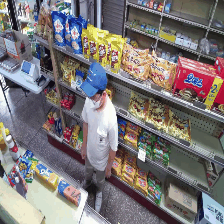

In [58]:
display_gif(sample_test_video['video'])

In [59]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [60]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "./videomae-base-model/checkpoint-300"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

logits = run_inference(model, sample_test_video["video"])

In [61]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: catch
